In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display

import numpy as np

import plot

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, f1_score

from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle

In [3]:
CAREER_LENGTH = 5

#EARLY_CAREER_LEN_LIST = [1, 2, 3, 4, 5]
EARLY_CAREER_LEN_LIST = [3]
EARLY_CAREER = 3
#RECOGNITION_CUT_OFF_LIST = [3, 4, 5, 6, 7, 8, 9]
RECOGNITION_CUT_OFF_LIST = [3]
RECOGNITION_CUT = 3

MAX_CAREER_LEN = 15
END_YEAR = 2018

INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 0
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1

# if true, all authors with gender=none are removed from cohort
REMOVE_NONE_AUTHORS = False

In [4]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended.csv')

In [5]:
credible_authors.columns
#print(credible_authors.groupby("start_year")['dropped_after_10'].agg('sum'))
#print(credible_authors.groupby("start_year")['author'].count())

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_degree_5',
       'early_career_degree_7', 'early_career_degree_9',
       'early_career_degree_11', 'early_career_degree_12',
       'early_career_qual_3', 'early_career_qual_5', 'early_career_qual_7',
       'early_career_qual_9', 'early_career_qual_11', 'early_career_qual_12',
       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC5_RC5',
       'early_career_recognition_EC7_RC7', 'early_career_recognition_EC9_RC9',
       'early_career_recognition_EC11_RC11',
       'early_career_recognition_EC12_RC12', 'succ_after_15y', 'h-index_3',
       'h-index_5', 'h-index_7', 'h-index_9', 'h-index_11', 'h-index_12',
       'h-index_15', 'early_career_prod_3', 'early_career_prod_5',
       'early_career_prod_7', 'early_career_prod_9', 'early_career_prod_11',
       'early_career_p

In [6]:
credible_authors = credible_authors[credible_authors.career_length >= CAREER_LENGTH]

In [7]:
# credible_authors['citation_increase_15_3'] = credible_authors['succ_after_15y'] - credible_authors[
#     'early_career_recognition_EC3_RC3']
# credible_authors['h_index_increase_15_3'] = credible_authors['h-index_15'] - credible_authors['h-index_3']

In [8]:
EARLY_CAREER_LEN_LIST_EXT = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST_EXT = [3,5,7,9,11,12]

for year in EARLY_CAREER_LEN_LIST_EXT:
    credible_authors[f'citation_increase_15_{year}'] = credible_authors['succ_after_15y'] - credible_authors[
        f'early_career_recognition_EC{year}_RC{year}']
    credible_authors[f'h_index_increase_15_{year}'] = credible_authors['h-index_15'] - credible_authors[f'h-index_{year}']

## Data first look

In [9]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_degree_5',
       'early_career_degree_7', 'early_career_degree_9',
       'early_career_degree_11', 'early_career_degree_12',
       'early_career_qual_3', 'early_career_qual_5', 'early_career_qual_7',
       'early_career_qual_9', 'early_career_qual_11', 'early_career_qual_12',
       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC5_RC5',
       'early_career_recognition_EC7_RC7', 'early_career_recognition_EC9_RC9',
       'early_career_recognition_EC11_RC11',
       'early_career_recognition_EC12_RC12', 'succ_after_15y', 'h-index_3',
       'h-index_5', 'h-index_7', 'h-index_9', 'h-index_11', 'h-index_12',
       'h-index_15', 'early_career_prod_3', 'early_career_prod_5',
       'early_career_prod_7', 'early_career_prod_9', 'early_career_prod_11',
       'early_career_p

In [10]:
credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender,early_career_degree_3,...,citation_increase_15_5,h_index_increase_15_5,citation_increase_15_7,h_index_increase_15_7,citation_increase_15_9,h_index_increase_15_9,citation_increase_15_11,h_index_increase_15_11,citation_increase_15_12,h_index_increase_15_12
0,'maseka lesaoana,2001,2015,2,15,14,5.0000,True,none,2.0,...,18.0,0.0,13.0,0.0,9.0,0.0,8.0,0.0,7.0,0.0
3,a aart blokhuis,1992,2005,2,14,13,5.0000,True,none,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,a min tjoa,1979,2017,191,39,7,0.9375,False,none,0.0,...,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0
18,a-imam al-sammak,1992,2006,3,15,13,3.7500,True,m,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,a-long jin,2011,2016,9,6,10,1.5000,True,none,0.0,...,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Correlations

In [11]:
cols = ['succ_after_15y', 'h_index_increase_15_3', 'citation_increase_15_3', 'max_absence-0-15', 
        'early_career_prod_3', 'early_career_degree_3', 'early_career_coauthor_max_hindex_12', 
        'early_career_recognition_EC3_RC3', 'early_career_qual_12']

col_names_short = ['succ', 'hindex_incr', 'cit_incr', 'max_abs', 
        'prod_3', 'degree_3', 'maxh_3', 
        'rec_3', 'qual_3']


In [12]:
cor_qual = credible_authors[cols].corr(method='kendall')

In [13]:
cor_qual
#cor_qual['succ_after_15y'].sort_values()

,succ_after_15y,h_index_increase_15_3,citation_increase_15_3,max_absence-0-15,early_career_prod_3,early_career_degree_3,early_career_coauthor_max_hindex_12,early_career_recognition_EC3_RC3,early_career_qual_12
succ_after_15y,1.000000,0.670024,0.959225,-0.381272,0.374344,0.329193,0.442461,0.454743,0.984458
h_index_increase_15_3,0.670024,1.000000,0.705401,-0.475731,0.321888,0.211670,0.400382,0.152340,0.661042
citation_increase_15_3,0.959225,0.705401,1.000000,-0.399140,0.356535,0.305645,0.433321,0.397753,0.944442
max_absence-0-15,-0.381272,-0.475731,-0.399140,1.000000,-0.169187,-0.060320,-0.205981,-0.065267,-0.376498
early_career_prod_3,0.374344,0.321888,0.356535,-0.169187,1.000000,0.434038,0.310385,0.427033,0.379657
early_career_degree_3,0.329193,0.211670,0.305645,-0.060320,0.434038,1.000000,0.343498,0.439623,0.335628
early_career_coauthor_max_hindex_12,0.442461,0.400382,0.433321,-0.205981,0.310385,0.343498,1.000000,0.322442,0.447471
early_career_recognition_EC3_RC3,0.454743,0.152340,0.397753,-0.065267,0.427033,0.439623,0.322442,1.000000,0.461401
early_career_qual_12,0.984458,0.661042,0.944442,-0.376498,0.379657,0.335628,0.447471,0.461401,1.000000


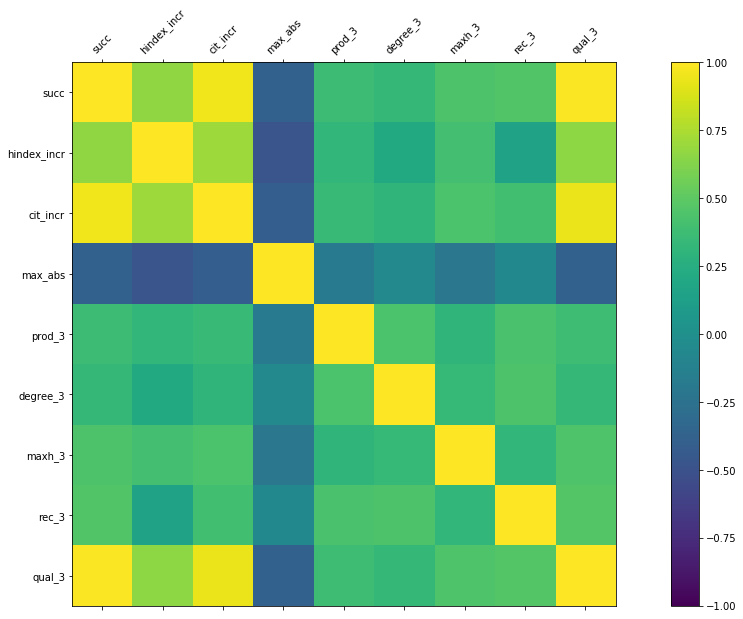

In [14]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cor_qual, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(col_names_short, rotation=45)
ax.set_yticklabels(col_names_short)
plt.show()


In [15]:
#cor = credible_authors.corr()

In [16]:
#cor_qual[f'h_index_increase_15_{EARLY_CAREER}'].sort_values()

In [17]:
# sns.heatmap(cor, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear reg

### Test different predictors

In [18]:
# test different early career lenghts

In [19]:
year = 1995

credible_authors_1991 = credible_authors[credible_authors.start_year == year]

In [20]:
X = credible_authors_1991.copy()


In [21]:
categorical_cols = ['gender']

for col in categorical_cols:
    X = X.join(pd.get_dummies(X[categorical_cols]))

X.drop(categorical_cols, axis=1, inplace=True)

In [22]:
def run_linear(func, name):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            reg = func.fit(H, y)
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': reg.score(H, y)}, ignore_index=True)
    return df

In [23]:
def run_cv(func, name, cv, y_col='succ_after_15y'):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            y = X[y_col]
            score = np.mean(cross_val_score(func, H, y, cv=cv, scoring='r2'))
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': score}, ignore_index=True)
    return df

In [24]:
df1 = run_cv(LinearRegression(), 'linear', cv=3)

In [25]:
# df1_null = run_cv(LinearRegression(), 'linear_null', cv=3, y_col='succ_shuffled')

In [26]:
df2 = run_cv(ElasticNet(), 'elastic', cv=3)

In [27]:
df3 = run_cv(ElasticNetCV(cv=3), 'elastic_CV', cv=3)

In [28]:
df4 = run_cv(Lasso(alpha=0.1), 'lasso', cv=3)

In [29]:
# Decision tree overfits pretty bad. Maybe GridParam Search?
df5 = run_cv(DecisionTreeRegressor(), 'tree', cv=3)

In [30]:
df6 = run_cv(RandomForestRegressor(), 'forest', cv=3)

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [31]:
# df6_null = run_cv(RandomForestRegressor(), 'forest_null', cv=3, y_col='succ_shuffled')

In [32]:
dfs = [df1, df2, df3, df4, df5, df6] #df1_null, df6_null
for df_ in dfs: df_.set_index('params', inplace=True)

In [33]:
dfs[0].join(dfs[1:])

,r_squared_linear,r_squared_elastic,r_squared_elastic_CV,r_squared_lasso,r_squared_tree,r_squared_forest
params,,,,,,
"EC:3,REC:3",0.331733,0.331811,0.31961,0.33177,-0.646009,0.035203


### Elastic net

In [34]:
years = sorted(credible_authors.start_year.unique())
cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LEN)]
# EARLY_CAREER = EARLY_CAREER_LEN_LIST[0]
# RECOGNITION_CUT = RECOGNITION_CUT_OFF_LIST[0]
EARLY_CAREER_LEN_LIST = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST = [3,5,7,9,11,12]

In [35]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [36]:
# 4 groups of features: productivity, social capital, quality/rec and gender
def make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, 
                    EARLY_CAREER, RECOGNITION_CUT):
    cols_std = []
    cols_all = ['cohort_size']

    if(INCLUDE_PROD):
        cols_std.append(f'early_career_prod_{EARLY_CAREER}')
        cols_all.append(f'early_career_prod_{EARLY_CAREER}')

    if(INCLUDE_SOCIAL):
        cols_std.append(f'early_career_degree_{EARLY_CAREER}')
        cols_all.append(f'early_career_degree_{EARLY_CAREER}')
        cols_std.append(f'early_career_coauthor_max_hindex_{EARLY_CAREER}')
        cols_all.append(f'early_career_coauthor_max_hindex_{EARLY_CAREER}')
    #     cols_std.append(f'early_career_coauthor_max_cit_{EARLY_CAREER}')
    #     cols_all.append(f'early_career_coauthor_max_cit_{EARLY_CAREER}')

    if(INCLUDE_REC):
        cols_std.append(f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}')
        cols_all.append(f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}')

    if(INCLUDE_QUALITY):
        cols_std.append(  f'early_career_qual_{EARLY_CAREER}')
        cols_all.append(  f'early_career_qual_{EARLY_CAREER}')

    if(INCLUDE_GENDER):
        cols_all.append('gender_m')
        cols_all.append('gender_f')
        if(not REMOVE_NONE_AUTHORS):
            cols_all.append('gender_none')


    cols_all.append('intercept')
    cols_all.append('r2')
    categorical_cols = ['gender']
    return cols_all, cols_std, categorical_cols
num_splits = 5

In [37]:
def run_elastic_net_cohort(credible_authors,cols_all, cols_std, categorical_cols, EARLY_CAREER):
    aggregated = False
    hindex_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    citation_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    dropout_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    for year in cohort_start_years:
        credible_authors_year = credible_authors[credible_authors.start_year == year]
        X = credible_authors_year.copy()
        
        hindex_data, citation_data, dropout_data = run_elastic_net(X, cols_std, categorical_cols, EARLY_CAREER, year, aggregated)
       
        hindex_table = hindex_table.join(hindex_data)
        citation_table = citation_table.join(citation_data)
        dropout_table = dropout_table.join(dropout_data)
        
    return hindex_table, citation_table, dropout_table

def run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, EARLY_CAREER):
        
    aggregated = True
    #add cohort start year as var
    categorical_cols.append("start_year")
    
    X = credible_authors.copy()
    
    return run_elastic_net(X, cols_std, categorical_cols, EARLY_CAREER, year=0, aggregated)
    


def run_elastic_net(X, cols_std, categorical_cols, EARLY_CAREER, year=0, aggregated):
   
    #remove non-gender rows
    if(REMOVE_NONE_AUTHORS):
        X = X[X["gender"]!="none"]

   
    # Make dummy values for categorical columns
    cat_cols = pd.get_dummies(X[categorical_cols])

    
    #if(not REMOVE_NONE_AUTHORS):
        # drop gender none?
         # this is removing rows gender_none col
        #gender_cols.drop('gender_none', axis=1, inplace=True)

    #standardize cols_std
    if len(cols_std)>0:
        standardized_cols = RobustScaler().fit_transform(X[cols_std])
        H = pd.DataFrame(standardized_cols, index=X.index, columns=cols_std)
    else:
        H = pd.DataFrame(index=X.index, columns=cols_std)
       
    H = H.join(cat_cols) 
    if(not INCLUDE_GENDER):
        H = H.drop(columns=['gender_f',  'gender_m',  'gender_none'])
    
    print(H.head())
    
    y = X[f'h_index_increase_15_{EARLY_CAREER}']
    y2 = X[f'citation_increase_15_{EARLY_CAREER}']
    y3 = X['dropped_after_10'].astype(int)

    #cv_dict = cross_validate(LinearRegressionCV(cv=3), H, y, scoring='r2', cv=10, return_estimator=True, return_train_score=False)
    #cv2_dict = cross_validate(LinearRegressionCV(cv=3), H, y2, scoring='r2', cv=10, return_estimator=True, return_train_score=False)
    #cv3_dict = cross_validate(LogisticRegressionCV(cv=3, penalty='l2'), H, y3, scoring="f1", cv=10, return_estimator=True, return_train_score=False)
    cv_dict = cross_validate(ElasticNetCV(cv=3), H, y, scoring='r2', cv=10, return_estimator=True, return_train_score=False)
    cv2_dict = cross_validate(ElasticNetCV(cv=3), H, y2, scoring='r2', cv=10, return_estimator=True, return_train_score=False)
    cv3_dict = cross_validate(LogisticRegressionCV(cv=3, penalty='l2'), H, y3, scoring="f1", cv=10, return_estimator=True, return_train_score=False)
          
    score = np.mean(cv_dict['test_score'])
    score2 = np.mean(cv2_dict['test_score'])
    score3 = np.mean(cv3_dict['test_score'])

    net_coef = pd.DataFrame([es.coef_ for es in cv_dict['estimator']], columns=H.columns)
    net2_coef = pd.DataFrame([es.coef_ for es in cv2_dict['estimator']], columns=H.columns)
    net3_coef = pd.DataFrame([es.coef_[0] for es in cv3_dict['estimator']], columns=H.columns)

    net_intercept = np.mean([es.intercept_ for es in cv_dict['estimator']])
    net2_intercept = np.mean([es.intercept_ for es in cv2_dict['estimator']])
    net3_intercept = np.mean([es.intercept_ for es in cv3_dict['estimator']])

    net_coef_mean, net2_coef_mean, net3_coef_mean = net_coef.mean(), net2_coef.mean(), net3_coef.mean()
    net_coef_std, net2_coef_std, net3_coef_std = net_coef.std(), net2_coef.std(), net3_coef.std()

    rounding = 2

    net_coef_mean_std = list(zip(np.round(net_coef_mean.values,rounding), np.round(net_coef_std.values,rounding)))
    net2_coef_mean_std = list(zip(np.round(net2_coef_mean.values,rounding), np.round(net2_coef_std.values,rounding)))
    net3_coef_mean_std = list(zip(np.round(net3_coef_mean.values,rounding), np.round(net3_coef_std.values,rounding)))
        
    net_coef_mean_std = [f"{x[0]}({x[1]})" for x in net_coef_mean_std]
    net2_coef_mean_std = [f"{x[0]}({x[1]})" for x in net2_coef_mean_std]
    net3_coef_mean_std = [f"{x[0]}({x[1]})" for x in net3_coef_mean_std]

    cohort_size = len(y2)
    #     num_nonzero_coefs = sum(net2.coef_ != 0)
    #     adj_score2 = 1 - (1-score2)*(cohort_size-1)/(cohort_size-num_nonzero_coefs-1)
    net_coef_mean_std.extend([np.round(net_intercept, rounding), np.round(score, rounding), cohort_size])
    net2_coef_mean_std.extend([np.round(net2_intercept, rounding), np.round(score2, rounding), cohort_size])
    net3_coef_mean_std.extend([np.round(net3_intercept, rounding), np.round(score3, rounding), cohort_size])

    if(year>0):
        hindex_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                              net_coef_mean_std)), 
                                     columns=['year', year]).set_index('year')
        citation_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                              net2_coef_mean_std)), 
                                     columns=['year', year]).set_index('year')
        dropout_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                              net3_coef_mean_std)),
                                     columns=['year', year]).set_index('year')
    else:
        hindex_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                              net_coef_mean_std)))
        citation_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                              net2_coef_mean_std)))                                  
        dropout_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                              net3_coef_mean_std)))
    
    return hindex_data, citation_data, dropout_data

#### Feature tables

In [38]:
def make_result_table(feature_table):
    results = feature_table.transpose()
    #shorten column names
    new_cols = dict(zip(results.columns, [col.replace('early_career', 'ec') for col in results.columns]))

    results.rename(new_cols, axis='columns', inplace=True)
    results.rename({'feature':'cohort','ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)
    return results

In [39]:
def results_to_latex(results, name):
    ltx_file = open(f"results_{name}.tex", "w")
    ltx_file.write('\n'.join(results.to_latex().split('\n')[4:-3]))
    ltx_file.close()

In [40]:
EARLY_CAREER = 3
RECOGNITION_CUT = 3

## Aggregated Elastic Net Models
First we test the effect of different groups of features (human capital, social capital and gender) on success/dropout

In [41]:
#MODEL 1: null model

INCLUDE_PROD = 0
INCLUDE_SOCIAL = 0
INCLUDE_REC = 0
INCLUDE_GENDER = 0
INCLUDE_QUALITY = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, 
                                                       INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)

#hindex_table, citation_table, dropout_table =  run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER)


hindex_table, citation_table, dropout_table = run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, EARLY_CAREER)



#hindex_table, citation_table, dropout_table =  run_elastic_net_cohort(credible_authors, cols_all, cols_std, categorical_cols, EARLY_CAREER)
#results_hindex = make_result_table(hindex_table)
#results_citation = make_result_table(citation_table)
#results_dropouts = make_result_table(dropout_table)


    start_year
0         2001
3         1992
9         1979
18        1992
19        2011


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

In [42]:
print("hindex_table")
print(hindex_table)
print("citation_table")
print(citation_table)
print("dropout_table")
print(dropout_table)

hindex_table
             0           1
0   start_year  -0.04(0.0)
1    intercept       75.37
2           r2        0.01
3  cohort_size      503859
citation_table
             0            1
0   start_year  -1.67(0.04)
1    intercept      3411.48
2           r2            0
3  cohort_size       503859
dropout_table
             0          1
0   start_year  -0.0(0.0)
1    intercept         -0
2           r2          0
3  cohort_size     503859


In [43]:
#MODEL 2: gender effect model

INCLUDE_PROD = 1
INCLUDE_SOCIAL = 0
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, 
                                                       INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)

hindex_table, citation_table, dropout_table = run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, EARLY_CAREER)
print("hindex_table")
print(hindex_table)
print("citation_table")
print(citation_table)
print("dropout_table")
print(dropout_table)

#feature_table, feature_table2, feature_table3 = run_elastic_net_cohort(cols_all, cols_std, categorical_cols, EARLY_CAREER)
#results = make_result_table(feature_table)
#results2 = make_result_table(feature_table2)
#results3 = make_result_table(feature_table3)



    early_career_prod_3  early_career_recognition_EC3_RC3  start_year  \
0                  -0.5                              0.25        2001   
3                  -0.5                             -0.25        1992   
9                  -0.5                             -0.25        1979   
18                 -0.5                             -0.25        1992   
19                 -0.5                             -0.25        2011   

    gender_f  gender_m  gender_none  
0          0         0            1  
3          0         0            1  
9          0         0            1  
18         0         1            0  
19         0         0            1  
hindex_table
                                  0            1
0               early_career_prod_3     0.8(0.0)
1  early_career_recognition_EC3_RC3    0.12(0.0)
2                        start_year   -0.06(0.0)
3                          gender_f  -0.09(0.01)
4                          gender_m    0.0(0.01)
5                       ge

In [44]:
#MODEL 3: social capital effect model

INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, 
                                                       INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)

#feature_table, feature_table2, feature_table3 = run_elastic_bet_cohort(cols_all, cols_std, categorical_cols, EARLY_CAREER)
#results = make_result_table(feature_table)
#results2 = make_result_table(feature_table2)
#results3 = make_result_table(feature_table3)

hindex_table, citation_table, dropout_table = run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, EARLY_CAREER)
print("hindex_table")
print(hindex_table)
print("citation_table")
print(citation_table)
print("dropout_table")
print(dropout_table)

    early_career_prod_3  early_career_degree_3  \
0                  -0.5                  -0.25   
3                  -0.5                  -0.75   
9                  -0.5                  -0.75   
18                 -0.5                  -0.75   
19                 -0.5                  -0.75   

    early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
0                             0.666667                              0.25   
3                            -0.333333                             -0.25   
9                            -0.333333                             -0.25   
18                           -0.333333                             -0.25   
19                           -0.333333                             -0.25   

    start_year  gender_f  gender_m  gender_none  
0         2001         0         0            1  
3         1992         0         0            1  
9         1979         0         0            1  
18        1992         0         1        

In [45]:
#MODEL 4: full model
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, 
                                                       INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)

In [46]:
hindex_table, citation_table, dropout_table = run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, EARLY_CAREER)
print("hindex_table")
print(hindex_table)
print("citation_table")
print(citation_table)
print("dropout_table")
print(dropout_table)

    early_career_prod_3  early_career_degree_3  \
0                  -0.5                  -0.25   
3                  -0.5                  -0.75   
9                  -0.5                  -0.75   
18                 -0.5                  -0.75   
19                 -0.5                  -0.75   

    early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
0                             0.666667                              0.25   
3                            -0.333333                             -0.25   
9                            -0.333333                             -0.25   
18                           -0.333333                             -0.25   
19                           -0.333333                             -0.25   

    early_career_qual_3  start_year  gender_f  gender_m  gender_none  
0                  0.85        2001         0         0            1  
3                 -0.30        1992         0         0            1  
9                 -0.30      

## Cohort Elastic Net Models
Second we compare the predictive performance across cohorts. We should plot R2 and F1 over cohorts.
Is predictive performance stable?

In [47]:
#full model
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, 
                                                       INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_net_cohort(credible_authors, cols_all, cols_std, categorical_cols, EARLY_CAREER)

results = make_result_table(feature_table)
results2 = make_result_table(feature_table2)
results3 = make_result_table(feature_table3)



       early_career_prod_3  early_career_degree_3  \
8272                   0.0                    1.0   
11907                  0.0                    0.0   
24647                  0.0                    0.0   
40749                  0.0                    0.0   
41689                  2.0                    2.0   

       early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
8272                                  0.0                               0.0   
11907                                 0.0                               0.0   
24647                                 0.0                               0.0   
40749                                 0.0                               2.5   
41689                                 0.0                               4.0   

       early_career_qual_3  gender_f  gender_m  gender_none  
8272              0.428571         0         1            0  
11907            -0.142857         0         1            0  
24647            -0.

      early_career_prod_3  early_career_degree_3  \
3981                  2.0                    1.5   
5050                  0.0                   -0.5   
5737                  0.0                    0.5   
5971                  0.0                    0.5   
9135                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
3981                                 2.0                               1.0   
5050                                 0.0                               0.0   
5737                                 0.0                               1.5   
5971                                 3.0                               0.0   
9135                                 1.0                               0.5   

      early_career_qual_3  gender_f  gender_m  gender_none  
3981                2.500         0         1            0  
5050               -0.250         0         1            0  
5737                2.125         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
1226                  0.0                   -0.5   
2533                  0.0                   -0.5   
4388                  1.0                    0.5   
4528                  0.0                   -0.5   
4572                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
1226                                 0.0                               0.0   
2533                                 0.0                               0.0   
4388                                 0.0                               0.0   
4528                                 0.0                               0.0   
4572                                 2.0                               0.0   

      early_career_qual_3  gender_f  gender_m  gender_none  
1226            -0.250000         0         1            0  
2533            -0.250000         0         1            0  
4388             0.000000         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
575                   0.0               1.000000   
589                   0.5               0.666667   
1224                  0.0               0.666667   
1824                  0.0              -0.333333   
1949                  0.0              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
575                                  2.5                          0.333333   
589                                  0.5                          0.000000   
1224                                 2.0                          0.000000   
1824                                 0.0                         -0.333333   
1949                                 0.0                         -0.333333   

      early_career_qual_3  gender_f  gender_m  gender_none  
575             -0.173913         0         1            0  
589              0.115942         0         1            0  
1224             0.347826         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
247                  -0.5                   -1.0   
914                  -0.5                    0.0   
1549                 -0.5                    0.0   
1861                 -0.5                   -0.5   
1919                 -0.5                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
247                             0.000000                              -0.5   
914                             0.000000                              -0.5   
1549                            0.333333                               0.0   
1861                            0.666667                              -0.5   
1919                            1.333333                               0.0   

      early_career_qual_3  gender_f  gender_m  gender_none  
247             -0.294118         0         1            0  
914             -0.235294         0         1            0  
1549             0.176471         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
43                   -0.5              -0.333333   
155                  -0.5              -0.333333   
928                   0.5              -0.666667   
1002                 -0.5              -0.666667   
1312                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
43                             -0.333333                         -0.333333   
155                            -0.333333                          0.000000   
928                            -0.333333                         -0.333333   
1002                           -0.333333                         -0.333333   
1312                           -0.333333                         -0.333333   

      early_career_qual_3  gender_f  gender_m  gender_none  
43               0.000000         0         1            0  
155             -0.055556         0         1            0  
928             -0.277778         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
50                    0.5               0.000000   
1820                 -0.5              -0.666667   
1988                 -0.5              -0.333333   
2362                  0.5               1.333333   
2953                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
50                              0.000000                          0.666667   
1820                           -0.333333                         -0.333333   
1988                           -0.333333                          0.666667   
2362                            0.333333                         -0.333333   
2953                           -0.333333                         -0.333333   

      early_career_qual_3  gender_f  gender_m  gender_none  
50               0.000000         0         1            0  
1820            -0.263158         0         1            0  
1988             0.789474         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
387                  -0.5              -0.666667   
576                  -0.5              -0.666667   
1317                 -0.5              -0.666667   
2136                  0.0               1.333333   
2899                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
387                                -0.25                         -0.333333   
576                                -0.25                         -0.333333   
1317                               -0.25                         -0.333333   
2136                                0.00                         -0.333333   
2899                               -0.25                         -0.333333   

      early_career_qual_3  gender_f  gender_m  gender_none  
387                 -0.30         0         1            0  
576                 -0.30         0         1            0  
1317                -0.30         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
29                   -0.5              -0.666667   
591                  -0.5               0.666667   
830                   0.5               0.000000   
1403                 -0.5              -0.666667   
2148                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
29                                 -0.25                         -0.333333   
591                                -0.25                          0.333333   
830                                 0.00                         -0.333333   
1403                               -0.25                         -0.333333   
2148                               -0.25                         -0.333333   

      early_career_qual_3  gender_f  gender_m  gender_none  
29              -0.285714         0         0            1  
591              0.047619         0         1            0  
830              0.095238         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
484                  -0.5               0.000000   
885                  -0.5               0.000000   
1402                 -0.5               0.000000   
1489                 -0.5              -0.666667   
1535                 -0.5              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
484                                -0.25                         -0.333333   
885                                 0.00                         -0.333333   
1402                               -0.25                         -0.333333   
1489                               -0.25                         -0.333333   
1535                               -0.25                         -0.333333   

      early_career_qual_3  gender_f  gender_m  gender_none  
484             -0.208333         0         1            0  
885             -0.166667         0         1            0  
1402            -0.208333         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
132                 -0.5              -0.666667   
226                  1.0               0.000000   
334                 -0.5              -0.666667   
415                  2.5               0.333333   
765                 -0.5              -0.666667   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
132                               -0.25                         -0.333333   
226                               -0.25                          0.000000   
334                               -0.25                          0.000000   
415                               -0.25                         -0.333333   
765                               -0.25                         -0.333333   

     early_career_qual_3  gender_f  gender_m  gender_none  
132                -0.28         0         1            0  
226                -0.08         0         1            0  
334                -0.16         0         1      

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
0                   -0.5                   0.00   
107                  0.0                  -0.25   
367                  0.0                  -0.50   
905                  0.5                   0.25   
997                 -0.5                   0.00   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
0                                   1.0                          0.333333   
107                                -0.2                         -0.333333   
367                                -0.2                         -0.333333   
905                                 1.0                          0.333333   
997                                -0.2                          0.000000   

     early_career_qual_3  gender_f  gender_m  gender_none  
0               0.592593         0         0            1  
107            -0.074074         0         1            0  
367            -0.259259         0         1      

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
173                   0.0                  -0.25   
739                   0.0                  -0.75   
875                   1.0                   2.75   
1180                  0.5                   0.00   
1388                 -0.5                   0.00   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
173                                 -0.4                              0.00   
739                                 -0.4                             -0.25   
875                                 -0.2                             -0.25   
1180                                 0.0                              0.75   
1388                                -0.2                              0.25   

      early_career_qual_3  gender_f  gender_m  gender_none  
173              1.034483         0         1            0  
739             -0.275862         0         0            1  
875             -0.103448         0

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

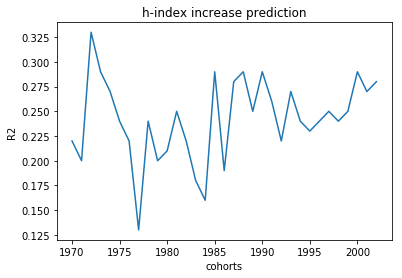

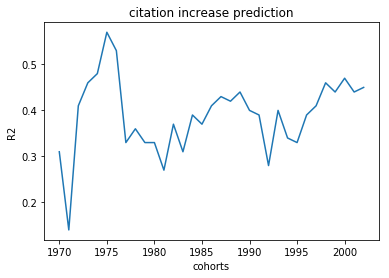

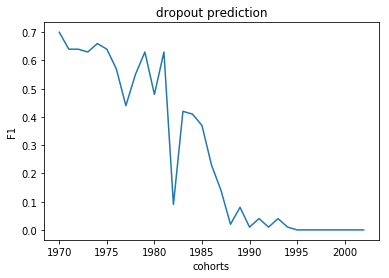

In [48]:
fig, ax = plt.subplots()
ax.plot(results.index, results[["r2"]])
ax.set(xlabel='cohorts', ylabel='R2',
       title='h-index increase prediction')
plt.show()

fig, ax = plt.subplots()
ax.plot(results2.index, results2[["r2"]])
ax.set(xlabel='cohorts', ylabel='R2',
       title='citation increase prediction')
plt.show()

fig, ax = plt.subplots()
ax.plot(results3.index, results3[["r2"]])
ax.set(xlabel='cohorts', ylabel='F1',
       title='dropout prediction')
plt.show()

In [49]:
# model without quality 
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, 
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_net_cohort(credible_authors, cols_all, cols_std, categorical_cols, EARLY_CAREER)
results_no_qual = make_result_table(feature_table)
results2_no_qual = make_result_table(feature_table2)
results3_no_qual = make_result_table(feature_table3)



       early_career_prod_3  early_career_degree_3  \
8272                   0.0                    1.0   
11907                  0.0                    0.0   
24647                  0.0                    0.0   
40749                  0.0                    0.0   
41689                  2.0                    2.0   

       early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
8272                                  0.0                               0.0   
11907                                 0.0                               0.0   
24647                                 0.0                               0.0   
40749                                 0.0                               2.5   
41689                                 0.0                               4.0   

       gender_f  gender_m  gender_none  
8272          0         1            0  
11907         0         1            0  
24647         1         0            0  
40749         0         1            0  
4

      early_career_prod_3  early_career_degree_3  \
3981                  2.0                    1.5   
5050                  0.0                   -0.5   
5737                  0.0                    0.5   
5971                  0.0                    0.5   
9135                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
3981                                 2.0                               1.0   
5050                                 0.0                               0.0   
5737                                 0.0                               1.5   
5971                                 3.0                               0.0   
9135                                 1.0                               0.5   

      gender_f  gender_m  gender_none  
3981         0         1            0  
5050         0         1            0  
5737         0         1            0  
5971         0         1            0  
9135         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
1226                  0.0                   -0.5   
2533                  0.0                   -0.5   
4388                  1.0                    0.5   
4528                  0.0                   -0.5   
4572                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
1226                                 0.0                               0.0   
2533                                 0.0                               0.0   
4388                                 0.0                               0.0   
4528                                 0.0                               0.0   
4572                                 2.0                               0.0   

      gender_f  gender_m  gender_none  
1226         0         1            0  
2533         0         1            0  
4388         0         1            0  
4528         0         1            0  
4572         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
575                   0.0               1.000000   
589                   0.5               0.666667   
1224                  0.0               0.666667   
1824                  0.0              -0.333333   
1949                  0.0              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
575                                  2.5                          0.333333   
589                                  0.5                          0.000000   
1224                                 2.0                          0.000000   
1824                                 0.0                         -0.333333   
1949                                 0.0                         -0.333333   

      gender_f  gender_m  gender_none  
575          0         1            0  
589          0         1            0  
1224         0         0            1  
1824         0         1            0  
1949         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
913                  -0.5              -0.666667   
1551                 -0.5               0.333333   
1596                 -0.5              -0.666667   
1790                  0.0               0.333333   
1893                 -0.5               0.000000   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
913                                  0.0                              -0.5   
1551                                 0.0                              -0.5   
1596                                 0.0                              -0.5   
1790                                 0.0                              -0.5   
1893                                 0.0                               1.5   

      gender_f  gender_m  gender_none  
913          0         1            0  
1551         0         1            0  
1596         0         1            0  
1790         0         1            0  
1893         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
247                  -0.5                   -1.0   
914                  -0.5                    0.0   
1549                 -0.5                    0.0   
1861                 -0.5                   -0.5   
1919                 -0.5                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
247                             0.000000                              -0.5   
914                             0.000000                              -0.5   
1549                            0.333333                               0.0   
1861                            0.666667                              -0.5   
1919                            1.333333                               0.0   

      gender_f  gender_m  gender_none  
247          0         1            0  
914          0         1            0  
1549         0         1            0  
1861         0         1            0  
1919         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
43                   -0.5              -0.333333   
155                  -0.5              -0.333333   
928                   0.5              -0.666667   
1002                 -0.5              -0.666667   
1312                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
43                             -0.333333                         -0.333333   
155                            -0.333333                          0.000000   
928                            -0.333333                         -0.333333   
1002                           -0.333333                         -0.333333   
1312                           -0.333333                         -0.333333   

      gender_f  gender_m  gender_none  
43           0         1            0  
155          0         1            0  
928          0         0            1  
1002         0         1            0  
1312         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
50                    0.5               0.000000   
1820                 -0.5              -0.666667   
1988                 -0.5              -0.333333   
2362                  0.5               1.333333   
2953                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
50                              0.000000                          0.666667   
1820                           -0.333333                         -0.333333   
1988                           -0.333333                          0.666667   
2362                            0.333333                         -0.333333   
2953                           -0.333333                         -0.333333   

      gender_f  gender_m  gender_none  
50           0         1            0  
1820         0         1            0  
1988         0         1            0  
2362         0         1            0  
2953         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
387                  -0.5              -0.666667   
576                  -0.5              -0.666667   
1317                 -0.5              -0.666667   
2136                  0.0               1.333333   
2899                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
387                                -0.25                         -0.333333   
576                                -0.25                         -0.333333   
1317                               -0.25                         -0.333333   
2136                                0.00                         -0.333333   
2899                               -0.25                         -0.333333   

      gender_f  gender_m  gender_none  
387          0         1            0  
576          0         1            0  
1317         0         1            0  
2136         0         0            1  
2899         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
29                   -0.5              -0.666667   
591                  -0.5               0.666667   
830                   0.5               0.000000   
1403                 -0.5              -0.666667   
2148                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
29                                 -0.25                         -0.333333   
591                                -0.25                          0.333333   
830                                 0.00                         -0.333333   
1403                               -0.25                         -0.333333   
2148                               -0.25                         -0.333333   

      gender_f  gender_m  gender_none  
29           0         0            1  
591          0         1            0  
830          0         0            1  
1403         0         1            0  
2148         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
484                  -0.5               0.000000   
885                  -0.5               0.000000   
1402                 -0.5               0.000000   
1489                 -0.5              -0.666667   
1535                 -0.5              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
484                                -0.25                         -0.333333   
885                                 0.00                         -0.333333   
1402                               -0.25                         -0.333333   
1489                               -0.25                         -0.333333   
1535                               -0.25                         -0.333333   

      gender_f  gender_m  gender_none  
484          0         1            0  
885          0         1            0  
1402         0         1            0  
1489         0         1            0  
1535         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
132                 -0.5              -0.666667   
226                  1.0               0.000000   
334                 -0.5              -0.666667   
415                  2.5               0.333333   
765                 -0.5              -0.666667   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
132                               -0.25                         -0.333333   
226                               -0.25                          0.000000   
334                               -0.25                          0.000000   
415                               -0.25                         -0.333333   
765                               -0.25                         -0.333333   

     gender_f  gender_m  gender_none  
132         0         1            0  
226         0         1            0  
334         0         1            0  
415         0         1            0  
765         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
0                   -0.5                   0.00   
107                  0.0                  -0.25   
367                  0.0                  -0.50   
905                  0.5                   0.25   
997                 -0.5                   0.00   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
0                                   1.0                          0.333333   
107                                -0.2                         -0.333333   
367                                -0.2                         -0.333333   
905                                 1.0                          0.333333   
997                                -0.2                          0.000000   

     gender_f  gender_m  gender_none  
0           0         0            1  
107         0         1            0  
367         0         1            0  
905         0         1            0  
997         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
173                   0.0                  -0.25   
739                   0.0                  -0.75   
875                   1.0                   2.75   
1180                  0.5                   0.00   
1388                 -0.5                   0.00   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
173                                 -0.4                              0.00   
739                                 -0.4                             -0.25   
875                                 -0.2                             -0.25   
1180                                 0.0                              0.75   
1388                                -0.2                              0.25   

      gender_f  gender_m  gender_none  
173          0         1            0  
739          0         0            1  
875          0         1            0  
1180         0         0            1  
1388         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

In [50]:
results3_no_qual

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,gender_m,gender_f,gender_none,intercept,r2
1970,390,-0.46(0.2),0.04(0.03),-0.04(0.07),-0.08(0.04),-0.15(0.08),-0.0(0.02),0.15(0.09),0.36,0.71
1971,508,-0.9(0.11),0.09(0.02),-0.38(0.31),-0.05(0.02),-0.17(0.07),0.07(0.07),0.1(0.06),0.3,0.65
1972,609,-0.49(0.17),0.19(0.08),0.06(0.12),-0.05(0.02),-0.07(0.04),-0.02(0.07),0.09(0.06),0.1,0.66
1973,767,-0.47(0.2),0.04(0.04),-0.01(0.04),-0.12(0.02),-0.01(0.02),-0.03(0.04),0.04(0.03),0.15,0.6
1974,847,-0.61(0.12),-0.05(0.02),-0.21(0.1),-0.04(0.02),-0.11(0.04),0.08(0.06),0.04(0.05),0.35,0.66
1975,813,-0.93(0.1),0.1(0.01),-0.0(0.04),0.04(0.03),-0.1(0.04),-0.05(0.06),0.15(0.05),0.24,0.64
1976,993,-0.68(0.13),-0.01(0.04),-0.09(0.04),0.0(0.01),-0.12(0.06),-0.07(0.1),0.19(0.07),0.16,0.56
1977,1073,-0.74(0.07),-0.01(0.04),0.05(0.03),0.02(0.02),-0.17(0.04),0.06(0.05),0.11(0.03),0.06,0.43
1978,1039,-0.81(0.03),0.08(0.03),-0.14(0.04),0.24(0.03),-0.22(0.03),0.22(0.06),0.01(0.04),0.2,0.56
1979,1291,-0.92(0.03),0.13(0.04),-0.14(0.02),-0.01(0.01),0.02(0.04),-0.12(0.07),0.11(0.05),0.14,0.62


In [51]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 0
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_net_cohort(credible_authors, cols_all, cols_std, categorical_cols, EARLY_CAREER)
results_no_gen = make_result_table(feature_table)
results2_no_gen = make_result_table(feature_table2)
results3_no_gen = make_result_table(feature_table3)



       early_career_prod_3  early_career_degree_3  \
8272                   0.0                    1.0   
11907                  0.0                    0.0   
24647                  0.0                    0.0   
40749                  0.0                    0.0   
41689                  2.0                    2.0   

       early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
8272                                  0.0                               0.0   
11907                                 0.0                               0.0   
24647                                 0.0                               0.0   
40749                                 0.0                               2.5   
41689                                 0.0                               4.0   

       early_career_qual_3  
8272              0.428571  
11907            -0.142857  
24647            -0.285714  
40749             0.857143  
41689             5.142857  
       early_career_prod_3  earl

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
3981                  2.0                    1.5   
5050                  0.0                   -0.5   
5737                  0.0                    0.5   
5971                  0.0                    0.5   
9135                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
3981                                 2.0                               1.0   
5050                                 0.0                               0.0   
5737                                 0.0                               1.5   
5971                                 3.0                               0.0   
9135                                 1.0                               0.5   

      early_career_qual_3  
3981                2.500  
5050               -0.250  
5737                2.125  
5971               -0.125  
9135                0.250  
      early_career_prod_3  early_career_degree_3  

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
1226                  0.0                   -0.5   
2533                  0.0                   -0.5   
4388                  1.0                    0.5   
4528                  0.0                   -0.5   
4572                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
1226                                 0.0                               0.0   
2533                                 0.0                               0.0   
4388                                 0.0                               0.0   
4528                                 0.0                               0.0   
4572                                 2.0                               0.0   

      early_career_qual_3  
1226            -0.250000  
2533            -0.250000  
4388             0.000000  
4528            -0.250000  
4572            -0.083333  
      early_career_prod_3  early_career_degree_3  

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
575                   0.0               1.000000   
589                   0.5               0.666667   
1224                  0.0               0.666667   
1824                  0.0              -0.333333   
1949                  0.0              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
575                                  2.5                          0.333333   
589                                  0.5                          0.000000   
1224                                 2.0                          0.000000   
1824                                 0.0                         -0.333333   
1949                                 0.0                         -0.333333   

      early_career_qual_3  
575             -0.173913  
589              0.115942  
1224             0.347826  
1824            -0.289855  
1949            -0.289855  
      early_career_prod_3  early_career_degree_3  

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     early_career_prod_3  early_career_degree_3  \
3                   -0.5              -0.666667   
18                  -0.5              -0.666667   
319                 -0.5              -0.666667   
345                 -0.5               0.000000   
354                 -0.5              -0.666667   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
3                                   0.0                         -0.333333   
18                                  0.0                         -0.333333   
319                                 0.0                         -0.333333   
345                                 0.0                          1.666667   
354                                 0.0                         -0.333333   

     early_career_qual_3  
3              -0.294118  
18             -0.294118  
319            -0.294118  
345             0.176471  
354            -0.294118  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
247                  -0.5                   -1.0   
914                  -0.5                    0.0   
1549                 -0.5                    0.0   
1861                 -0.5                   -0.5   
1919                 -0.5                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
247                             0.000000                              -0.5   
914                             0.000000                              -0.5   
1549                            0.333333                               0.0   
1861                            0.666667                              -0.5   
1919                            1.333333                               0.0   

      early_career_qual_3  
247             -0.294118  
914             -0.235294  
1549             0.176471  
1861            -0.235294  
1919            -0.235294  
      early_career_prod_3  early_career_degree_3  

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
43                   -0.5              -0.333333   
155                  -0.5              -0.333333   
928                   0.5              -0.666667   
1002                 -0.5              -0.666667   
1312                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
43                             -0.333333                         -0.333333   
155                            -0.333333                          0.000000   
928                            -0.333333                         -0.333333   
1002                           -0.333333                         -0.333333   
1312                           -0.333333                         -0.333333   

      early_career_qual_3  
43               0.000000  
155             -0.055556  
928             -0.277778  
1002            -0.277778  
1312            -0.277778  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
50                    0.5               0.000000   
1820                 -0.5              -0.666667   
1988                 -0.5              -0.333333   
2362                  0.5               1.333333   
2953                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
50                              0.000000                          0.666667   
1820                           -0.333333                         -0.333333   
1988                           -0.333333                          0.666667   
2362                            0.333333                         -0.333333   
2953                           -0.333333                         -0.333333   

      early_career_qual_3  
50               0.000000  
1820            -0.263158  
1988             0.789474  
2362             0.842105  
2953            -0.263158  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
387                  -0.5              -0.666667   
576                  -0.5              -0.666667   
1317                 -0.5              -0.666667   
2136                  0.0               1.333333   
2899                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
387                                -0.25                         -0.333333   
576                                -0.25                         -0.333333   
1317                               -0.25                         -0.333333   
2136                                0.00                         -0.333333   
2899                               -0.25                         -0.333333   

      early_career_qual_3  
387                 -0.30  
576                 -0.30  
1317                -0.30  
2136                -0.15  
2899                -0.30  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
29                   -0.5              -0.666667   
591                  -0.5               0.666667   
830                   0.5               0.000000   
1403                 -0.5              -0.666667   
2148                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
29                                 -0.25                         -0.333333   
591                                -0.25                          0.333333   
830                                 0.00                         -0.333333   
1403                               -0.25                         -0.333333   
2148                               -0.25                         -0.333333   

      early_career_qual_3  
29              -0.285714  
591              0.047619  
830              0.095238  
1403            -0.285714  
2148            -0.285714  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
484                  -0.5               0.000000   
885                  -0.5               0.000000   
1402                 -0.5               0.000000   
1489                 -0.5              -0.666667   
1535                 -0.5              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
484                                -0.25                         -0.333333   
885                                 0.00                         -0.333333   
1402                               -0.25                         -0.333333   
1489                               -0.25                         -0.333333   
1535                               -0.25                         -0.333333   

      early_career_qual_3  
484             -0.208333  
885             -0.166667  
1402            -0.208333  
1489            -0.250000  
1535            -0.250000  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
132                 -0.5              -0.666667   
226                  1.0               0.000000   
334                 -0.5              -0.666667   
415                  2.5               0.333333   
765                 -0.5              -0.666667   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
132                               -0.25                         -0.333333   
226                               -0.25                          0.000000   
334                               -0.25                          0.000000   
415                               -0.25                         -0.333333   
765                               -0.25                         -0.333333   

     early_career_qual_3  
132                -0.28  
226                -0.08  
334                -0.16  
415                 0.56  
765                -0.28  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
0                   -0.5                   0.00   
107                  0.0                  -0.25   
367                  0.0                  -0.50   
905                  0.5                   0.25   
997                 -0.5                   0.00   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
0                                   1.0                          0.333333   
107                                -0.2                         -0.333333   
367                                -0.2                         -0.333333   
905                                 1.0                          0.333333   
997                                -0.2                          0.000000   

     early_career_qual_3  
0               0.592593  
107            -0.074074  
367            -0.259259  
905             1.629630  
997            -0.222222  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
173                   0.0                  -0.25   
739                   0.0                  -0.75   
875                   1.0                   2.75   
1180                  0.5                   0.00   
1388                 -0.5                   0.00   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
173                                 -0.4                              0.00   
739                                 -0.4                             -0.25   
875                                 -0.2                             -0.25   
1180                                 0.0                              0.75   
1388                                -0.2                              0.25   

      early_career_qual_3  
173              1.034483  
739             -0.275862  
875             -0.103448  
1180            -0.034483  
1388            -0.137931  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

In [52]:
results3_no_gen

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,intercept,r2
1970,390,-0.56(0.09),0.08(0.03),-0.08(0.2),0.09(0.08),-0.15(0.05),0.35,0.71
1971,508,-0.85(0.11),0.09(0.03),-0.23(0.15),-0.04(0.02),-0.01(0.02),0.23,0.65
1972,609,-0.38(0.18),0.17(0.07),0.06(0.11),0.08(0.09),-0.15(0.05),0.06,0.64
1973,767,-0.55(0.16),0.11(0.06),-0.01(0.06),0.05(0.06),-0.38(0.11),0.15,0.62
1974,847,-0.63(0.08),-0.03(0.03),-0.22(0.1),0.01(0.02),-0.1(0.02),0.32,0.67
1975,813,-0.99(0.13),0.1(0.02),0.01(0.05),0.05(0.03),0.0(0.02),0.25,0.67
1976,993,-0.72(0.04),-0.0(0.05),-0.08(0.04),0.04(0.01),-0.03(0.01),0.15,0.63
1977,1073,-0.72(0.25),0.0(0.04),0.05(0.04),0.08(0.05),-0.05(0.03),-0.03,0.44
1978,1039,-0.71(0.06),0.07(0.04),-0.13(0.03),0.21(0.02),-0.02(0.03),0.06,0.63
1979,1291,-0.86(0.09),0.11(0.05),-0.12(0.02),0.07(0.03),-0.07(0.02),0.13,0.64


In [53]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 0
INCLUDE_QUALITY = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_net_cohort(credible_authors, cols_all, cols_std, categorical_cols, EARLY_CAREER)
results_no_qual_no_gen = make_result_table(feature_table)
results2_no_qual_no_gen = make_result_table(feature_table2)
results3_no_qual_no_gen = make_result_table(feature_table3)



       early_career_prod_3  early_career_degree_3  \
8272                   0.0                    1.0   
11907                  0.0                    0.0   
24647                  0.0                    0.0   
40749                  0.0                    0.0   
41689                  2.0                    2.0   

       early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
8272                                  0.0                               0.0  
11907                                 0.0                               0.0  
24647                                 0.0                               0.0  
40749                                 0.0                               2.5  
41689                                 0.0                               4.0  
       early_career_prod_3  early_career_degree_3  \
4026                   0.0                    0.0   
8554                   0.0                    0.0   
8705                   2.0                    0.0   
1

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
3981                  2.0                    1.5   
5050                  0.0                   -0.5   
5737                  0.0                    0.5   
5971                  0.0                    0.5   
9135                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
3981                                 2.0                               1.0  
5050                                 0.0                               0.0  
5737                                 0.0                               1.5  
5971                                 3.0                               0.0  
9135                                 1.0                               0.5  
      early_career_prod_3  early_career_degree_3  \
9                     0.0                   -0.5   
4439                  0.0                   -0.5   
4455                  2.0                    1.0   
5055             

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
1226                  0.0                   -0.5   
2533                  0.0                   -0.5   
4388                  1.0                    0.5   
4528                  0.0                   -0.5   
4572                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
1226                                 0.0                               0.0  
2533                                 0.0                               0.0  
4388                                 0.0                               0.0  
4528                                 0.0                               0.0  
4572                                 2.0                               0.0  
      early_career_prod_3  early_career_degree_3  \
948                   1.0                    0.5   
2672                  0.0                   -0.5   
2798                  1.0                    2.0   
4356             

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
913                  -0.5              -0.666667   
1551                 -0.5               0.333333   
1596                 -0.5              -0.666667   
1790                  0.0               0.333333   
1893                 -0.5               0.000000   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
913                                  0.0                              -0.5  
1551                                 0.0                              -0.5  
1596                                 0.0                              -0.5  
1790                                 0.0                              -0.5  
1893                                 0.0                               1.5  
     early_career_prod_3  early_career_degree_3  \
3                   -0.5              -0.666667   
18                  -0.5              -0.666667   
319                 -0.5              -0.666667   
345                 -

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
247                  -0.5                   -1.0   
914                  -0.5                    0.0   
1549                 -0.5                    0.0   
1861                 -0.5                   -0.5   
1919                 -0.5                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
247                             0.000000                              -0.5  
914                             0.000000                              -0.5  
1549                            0.333333                               0.0  
1861                            0.666667                              -0.5  
1919                            1.333333                               0.0  
      early_career_prod_3  early_career_degree_3  \
244                   0.0                    1.0   
610                  -0.5                   -1.0   
1066                  0.5                   -0.5   
1127             

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
43                   -0.5              -0.333333   
155                  -0.5              -0.333333   
928                   0.5              -0.666667   
1002                 -0.5              -0.666667   
1312                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
43                             -0.333333                         -0.333333  
155                            -0.333333                          0.000000  
928                            -0.333333                         -0.333333  
1002                           -0.333333                         -0.333333  
1312                           -0.333333                         -0.333333  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
50                    0.5               0.000000   
1820                 -0.5              -0.666667   
1988                 -0.5              -0.333333   
2362                  0.5               1.333333   
2953                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
50                              0.000000                          0.666667  
1820                           -0.333333                         -0.333333  
1988                           -0.333333                          0.666667  
2362                            0.333333                         -0.333333  
2953                           -0.333333                         -0.333333  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
387                  -0.5              -0.666667   
576                  -0.5              -0.666667   
1317                 -0.5              -0.666667   
2136                  0.0               1.333333   
2899                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
387                                -0.25                         -0.333333  
576                                -0.25                         -0.333333  
1317                               -0.25                         -0.333333  
2136                                0.00                         -0.333333  
2899                               -0.25                         -0.333333  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
29                   -0.5              -0.666667   
591                  -0.5               0.666667   
830                   0.5               0.000000   
1403                 -0.5              -0.666667   
2148                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
29                                 -0.25                         -0.333333  
591                                -0.25                          0.333333  
830                                 0.00                         -0.333333  
1403                               -0.25                         -0.333333  
2148                               -0.25                         -0.333333  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
484                  -0.5               0.000000   
885                  -0.5               0.000000   
1402                 -0.5               0.000000   
1489                 -0.5              -0.666667   
1535                 -0.5              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
484                                -0.25                         -0.333333  
885                                 0.00                         -0.333333  
1402                               -0.25                         -0.333333  
1489                               -0.25                         -0.333333  
1535                               -0.25                         -0.333333  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
132                 -0.5              -0.666667   
226                  1.0               0.000000   
334                 -0.5              -0.666667   
415                  2.5               0.333333   
765                 -0.5              -0.666667   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
132                               -0.25                         -0.333333  
226                               -0.25                          0.000000  
334                               -0.25                          0.000000  
415                               -0.25                         -0.333333  
765                               -0.25                         -0.333333  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
0                   -0.5                   0.00   
107                  0.0                  -0.25   
367                  0.0                  -0.50   
905                  0.5                   0.25   
997                 -0.5                   0.00   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
0                                   1.0                          0.333333  
107                                -0.2                         -0.333333  
367                                -0.2                         -0.333333  
905                                 1.0                          0.333333  
997                                -0.2                          0.000000  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
173                   0.0                  -0.25   
739                   0.0                  -0.75   
875                   1.0                   2.75   
1180                  0.5                   0.00   
1388                 -0.5                   0.00   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  
173                                 -0.4                              0.00  
739                                 -0.4                             -0.25  
875                                 -0.2                             -0.25  
1180                                 0.0                              0.75  
1388                                -0.2                              0.25  


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

In [54]:
results3_no_qual_no_gen

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,intercept,r2
1970,390,-0.55(0.09),0.05(0.03),0.02(0.23),-0.08(0.05),0.37,0.7
1971,508,-0.93(0.08),0.1(0.03),-0.47(0.36),-0.04(0.02),0.26,0.66
1972,609,-0.57(0.14),0.22(0.07),0.08(0.09),-0.03(0.03),0.1,0.66
1973,767,-0.39(0.15),0.03(0.04),-0.02(0.03),-0.11(0.02),0.13,0.59
1974,847,-0.64(0.08),-0.05(0.02),-0.21(0.09),-0.04(0.02),0.32,0.66
1975,813,-1.02(0.13),0.1(0.02),0.01(0.04),0.06(0.04),0.26,0.67
1976,993,-0.69(0.06),-0.01(0.05),-0.09(0.04),0.0(0.01),0.16,0.63
1977,1073,-0.7(0.25),0.0(0.03),0.04(0.04),0.02(0.03),-0.03,0.45
1978,1039,-0.77(0.07),0.08(0.04),-0.14(0.03),0.22(0.02),0.08,0.63
1979,1291,-0.87(0.08),0.11(0.05),-0.13(0.02),-0.01(0.01),0.16,0.63


In [55]:
results['r2_no_qual_no_gen'] = results_no_qual_no_gen['r2']
results2['r2_no_qual_no_gen'] = results2_no_qual_no_gen['r2']
results3['f1_no_qual_no_gen'] = results3_no_qual_no_gen['r2']

In [56]:
results['r2_no_qual'] = results_no_qual['r2']
results2['r2_no_qual'] = results2_no_qual['r2']
results3['f1_no_qual'] = results3_no_qual['r2']

In [57]:
results['r2_no_gen'] = results_no_gen['r2']
results2['r2_no_gen'] = results2_no_gen['r2']
results3['f1_no_gen'] = results3_no_gen['r2']

In [58]:
dropped_percent = credible_authors.groupby('start_year')['dropped_after_10'].sum() / credible_authors.groupby('start_year')['dropped_after_10'].count()

In [59]:
results3['drop_percentage'] = dropped_percent.round(2)

In [60]:
results3.columns

Index(['cohort_size', 'ec_prod_3', 'ec_degree_3', 'ec_coauthor_max_hindex_3',
       'ec_recognition_EC3_RC3', 'ec_qual_3', 'gender_m', 'gender_f',
       'gender_none', 'intercept', 'r2', 'f1_no_qual_no_gen', 'f1_no_qual',
       'f1_no_gen', 'drop_percentage'],
      dtype='object', name='feature')

In [61]:
results3 = results3.reindex([results3.columns[0]] + [results3.columns[-1]] + list(results3.columns[1:-1]), axis=1)

In [62]:
results2.shape

(33, 14)

In [63]:
results.tail()
#h_index_increase
# train_test results, compare with 'r2' col
# Year: 1999, r2: 0.29575585145072425
# Year: 2000, r2: 0.3288047075331689
# Year: 2001, r2: 0.32359617501275245
# Year: 2002, r2: 0.32367401156648834

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,r2_no_qual_no_gen,r2_no_qual,r2_no_gen
1998,13594,1.23(0.02),-0.04(0.01),0.63(0.03),-0.1(0.01),0.09(0.01),-0.01(0.01),-0.0(0.0),0.02(0.02),2.44,0.24,0.23,0.23,0.24
1999,14939,1.18(0.02),-0.02(0.01),0.6(0.02),-0.09(0.02),0.11(0.01),0.0(0.0),-0.02(0.02),0.04(0.03),2.46,0.25,0.23,0.23,0.25
2000,17593,1.19(0.01),-0.01(0.01),0.6(0.01),-0.07(0.01),0.13(0.0),0.0(0.0),-0.13(0.02),0.13(0.03),2.48,0.29,0.27,0.27,0.29
2001,19195,1.1(0.01),-0.03(0.0),0.79(0.01),-0.11(0.02),0.13(0.02),0.0(0.0),-0.11(0.02),0.09(0.03),2.49,0.27,0.25,0.25,0.27
2002,21220,1.0(0.01),0.03(0.01),0.67(0.01),-0.15(0.01),0.18(0.01),0.0(0.01),-0.16(0.03),0.06(0.02),2.57,0.28,0.26,0.26,0.28


In [64]:
results2.tail()
#citation_increase
# train_test results
# Year: 1999, r2: 0.26267137837811527
# Year: 2000, r2: 0.3229074740899605
# Year: 2001, r2: 0.2866603572613974
# Year: 2002, r2: 0.30948376141611045

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,r2_no_qual_no_gen,r2_no_qual,r2_no_gen
1998,13594,22.79(0.44),5.11(0.52),18.29(0.9),5.99(0.63),26.53(0.77),-0.07(0.13),0.0(0.0),0.0(0.01),60.64,0.46,0.31,0.31,0.46
1999,14939,23.37(0.82),5.75(0.34),18.05(0.69),4.46(1.1),32.07(0.92),0.0(0.0),-0.04(0.08),0.6(0.33),60.62,0.44,0.26,0.26,0.44
2000,17593,23.37(0.68),4.28(0.5),18.86(0.77),5.32(0.65),37.55(0.57),-0.02(0.07),-0.05(0.09),0.4(0.3),61.6,0.47,0.31,0.31,0.47
2001,19195,26.2(0.96),3.13(0.41),20.46(0.61),0.48(1.3),36.96(0.98),-0.0(0.01),-0.42(0.11),1.05(0.32),66.46,0.44,0.28,0.28,0.44
2002,21220,28.25(0.66),4.45(0.5),19.68(0.66),-2.74(0.56),42.93(0.35),-0.08(0.13),-0.56(0.18),1.42(0.38),63.9,0.45,0.28,0.28,0.45


In [65]:
results3.tail(4)
#dropouts
# train_test results
# Year: 1999, r2: 0.7871975797159264
# Year: 2000, r2: 0.7755906039107061
# Year: 2001, r2: 0.7776091854493229
# Year: 2002, r2: 0.7783668951214104

feature,cohort_size,drop_percentage,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,f1_no_qual_no_gen,f1_no_qual,f1_no_gen
1999,14939,0.24,-0.14(0.21),-0.02(0.02),-0.02(0.0),-0.01(0.02),-0.03(0.0),0.01(0.02),-0.0(0.01),-0.0(0.01),-1.09,0,0,0,0
2000,17593,0.23,-0.15(0.2),-0.02(0.02),-0.04(0.01),-0.01(0.01),-0.02(0.0),0.0(0.0),0.0(0.01),-0.01(0.01),-1.15,0,0,0,0
2001,19195,0.22,-0.08(0.0),-0.03(0.0),-0.02(0.0),-0.01(0.0),-0.02(0.0),0.0(0.0),0.0(0.0),-0.01(0.0),-1.21,0,0,0,0
2002,21220,0.22,-0.08(0.0),-0.02(0.0),-0.03(0.0),0.0(0.0),-0.03(0.0),-0.0(0.0),0.0(0.0),-0.0(0.0),-1.21,0,0,0,0


In [66]:
results_to_latex(results, 'hindex')
results_to_latex(results2, 'cit')
results_to_latex(results3, 'dropout')

In [67]:
results
# h index increase
#results.to_latex()

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,r2_no_qual_no_gen,r2_no_qual,r2_no_gen
1970,390,0.32(0.03),-0.06(0.03),0.1(0.31),-0.32(0.06),0.35(0.04),0.0(0.0),0.02(0.05),-0.0(0.01),0.97,0.22,0.15,0.15,0.22
1971,508,0.41(0.02),-0.0(0.01),0.0(0.0),-0.12(0.02),0.27(0.03),-0.0(0.01),0.0(0.0),0.0(0.0),0.82,0.2,0.11,0.12,0.2
1972,609,0.37(0.02),0.0(0.01),0.53(0.11),-0.53(0.03),0.34(0.02),0.0(0.01),-0.0(0.02),0.01(0.02),1,0.33,0.2,0.2,0.33
1973,767,0.35(0.03),0.01(0.01),0.0(0.0),-0.08(0.02),0.36(0.02),0.0(0.0),0.0(0.0),0.0(0.0),0.89,0.29,0.2,0.19,0.29
1974,847,0.42(0.02),-0.01(0.01),0.44(0.06),-0.08(0.01),0.15(0.01),0.18(0.05),-0.04(0.05),0.0(0.0),0.81,0.27,0.24,0.24,0.27
1975,813,0.46(0.02),0.02(0.01),0.21(0.06),-0.1(0.05),0.1(0.02),0.06(0.07),0.0(0.0),0.0(0.0),0.81,0.24,0.23,0.23,0.25
1976,993,0.63(0.02),0.03(0.02),0.14(0.03),-0.08(0.01),0.11(0.01),0.0(0.0),0.0(0.0),-0.0(0.01),0.89,0.22,0.2,0.2,0.22
1977,1073,0.4(0.07),0.05(0.03),0.14(0.05),-0.11(0.06),0.18(0.03),0.03(0.08),-0.01(0.02),0.0(0.0),1.16,0.13,0.11,0.1,0.13
1978,1039,0.48(0.05),-0.02(0.03),0.29(0.05),-0.22(0.04),0.24(0.03),0.0(0.0),-0.04(0.1),0.0(0.0),0.96,0.24,0.18,0.18,0.23
1979,1291,0.54(0.02),0.0(0.0),0.21(0.03),-0.17(0.03),0.17(0.02),0.0(0.0),0.0(0.0),0.0(0.0),1.23,0.2,0.16,0.16,0.2


In [68]:
results2
# citation increase

feature,cohort_size,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,r2_no_qual_no_gen,r2_no_qual,r2_no_gen
1970,390,4.62(1.03),-1.08(0.57),0.48(0.69),-3.2(1.77),12.19(1.33),-0.09(0.34),0.85(0.75),-0.17(0.29),11.83,0.31,0.22,0.22,0.31
1971,508,10.04(1.87),-1.17(0.8),4.65(2.52),-2.49(0.85),15.79(1.6),-2.75(1.44),1.92(1.07),0.31(0.4),6.03,0.14,-0.32,-0.33,0.14
1972,609,7.13(0.82),-0.75(0.48),8.0(1.73),-9.18(1.29),13.93(0.57),0.2(0.48),0.07(0.67),-0.45(0.74),9.74,0.41,0.16,0.17,0.42
1973,767,5.19(0.77),0.94(0.24),0.39(0.4),1.82(0.95),14.36(0.77),-0.05(0.14),0.0(0.0),0.06(0.12),5.8,0.46,0.24,0.25,0.46
1974,847,7.83(0.94),-0.95(0.57),4.78(1.38),-2.06(0.35),11.89(0.65),1.99(0.46),-0.8(0.34),-0.27(0.28),7.43,0.48,0.25,0.24,0.48
1975,813,7.7(0.71),0.36(0.19),1.3(0.59),-0.73(0.99),10.78(0.76),0.42(0.42),0.0(0.0),-0.16(0.25),7.19,0.57,0.35,0.36,0.57
1976,993,13.84(1.09),-1.39(0.52),5.13(1.24),-1.4(0.41),9.95(0.28),0.23(0.22),0.5(0.29),-1.53(0.39),6.39,0.53,0.33,0.33,0.54
1977,1073,8.12(1.19),1.85(0.66),4.57(0.96),1.53(0.84),12.92(0.38),-0.66(0.5),0.67(0.4),-0.09(0.28),14.9,0.33,0.24,0.25,0.33
1978,1039,10.31(1.12),-1.49(0.85),4.4(0.83),-2.44(1.4),15.23(0.94),0.0(0.0),-0.12(0.21),0.1(0.21),7.88,0.36,0.1,0.11,0.36
1979,1291,12.4(1.04),-1.1(0.66),7.51(0.64),-3.51(0.43),12.84(0.4),0.55(0.51),-0.26(0.25),-0.05(0.11),15.93,0.33,0.18,0.18,0.33


In [69]:
results3
# coefficients are not exponentiated
# positive means bigger change to drop

feature,cohort_size,drop_percentage,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,f1_no_qual_no_gen,f1_no_qual,f1_no_gen
1970,390,0.51,-0.53(0.17),0.07(0.04),-0.01(0.06),0.05(0.07),-0.13(0.04),-0.18(0.07),0.01(0.05),0.18(0.08),0.38,0.7,0.7,0.71,0.71
1971,508,0.43,-0.85(0.13),0.08(0.02),-0.32(0.33),-0.04(0.03),-0.01(0.02),-0.16(0.08),0.07(0.08),0.1(0.06),0.28,0.64,0.66,0.65,0.65
1972,609,0.47,-0.4(0.15),0.17(0.06),0.07(0.14),0.08(0.08),-0.15(0.05),-0.06(0.04),-0.02(0.07),0.08(0.06),0.07,0.64,0.66,0.66,0.64
1973,767,0.45,-0.57(0.12),0.12(0.05),-0.03(0.08),0.06(0.05),-0.4(0.1),-0.03(0.04),-0.02(0.06),0.05(0.05),0.16,0.63,0.59,0.6,0.62
1974,847,0.46,-0.65(0.07),-0.03(0.02),-0.24(0.09),0.01(0.02),-0.1(0.02),-0.13(0.03),0.12(0.08),0.02(0.06),0.38,0.66,0.66,0.66,0.67
1975,813,0.41,-0.93(0.09),0.1(0.02),0.0(0.05),0.04(0.03),0.0(0.02),-0.1(0.03),-0.04(0.03),0.15(0.03),0.24,0.64,0.67,0.64,0.67
1976,993,0.43,-0.71(0.13),-0.01(0.05),-0.08(0.05),0.04(0.02),-0.03(0.01),-0.12(0.06),-0.08(0.11),0.2(0.07),0.16,0.57,0.63,0.56,0.63
1977,1073,0.39,-0.75(0.06),-0.01(0.04),0.05(0.03),0.09(0.04),-0.05(0.03),-0.18(0.04),0.07(0.05),0.11(0.03),0.06,0.44,0.45,0.43,0.44
1978,1039,0.43,-0.78(0.04),0.08(0.04),-0.13(0.04),0.25(0.04),-0.02(0.03),-0.2(0.04),0.19(0.06),0.02(0.04),0.18,0.55,0.63,0.56,0.63
1979,1291,0.41,-0.91(0.03),0.12(0.04),-0.13(0.02),0.08(0.03),-0.07(0.02),0.02(0.04),-0.12(0.07),0.11(0.05),0.11,0.63,0.63,0.62,0.64


In [70]:
results3

feature,cohort_size,drop_percentage,ec_prod_3,ec_degree_3,ec_coauthor_max_hindex_3,ec_recognition_EC3_RC3,ec_qual_3,gender_m,gender_f,gender_none,intercept,r2,f1_no_qual_no_gen,f1_no_qual,f1_no_gen
1970,390,0.51,-0.53(0.17),0.07(0.04),-0.01(0.06),0.05(0.07),-0.13(0.04),-0.18(0.07),0.01(0.05),0.18(0.08),0.38,0.7,0.7,0.71,0.71
1971,508,0.43,-0.85(0.13),0.08(0.02),-0.32(0.33),-0.04(0.03),-0.01(0.02),-0.16(0.08),0.07(0.08),0.1(0.06),0.28,0.64,0.66,0.65,0.65
1972,609,0.47,-0.4(0.15),0.17(0.06),0.07(0.14),0.08(0.08),-0.15(0.05),-0.06(0.04),-0.02(0.07),0.08(0.06),0.07,0.64,0.66,0.66,0.64
1973,767,0.45,-0.57(0.12),0.12(0.05),-0.03(0.08),0.06(0.05),-0.4(0.1),-0.03(0.04),-0.02(0.06),0.05(0.05),0.16,0.63,0.59,0.6,0.62
1974,847,0.46,-0.65(0.07),-0.03(0.02),-0.24(0.09),0.01(0.02),-0.1(0.02),-0.13(0.03),0.12(0.08),0.02(0.06),0.38,0.66,0.66,0.66,0.67
1975,813,0.41,-0.93(0.09),0.1(0.02),0.0(0.05),0.04(0.03),0.0(0.02),-0.1(0.03),-0.04(0.03),0.15(0.03),0.24,0.64,0.67,0.64,0.67
1976,993,0.43,-0.71(0.13),-0.01(0.05),-0.08(0.05),0.04(0.02),-0.03(0.01),-0.12(0.06),-0.08(0.11),0.2(0.07),0.16,0.57,0.63,0.56,0.63
1977,1073,0.39,-0.75(0.06),-0.01(0.04),0.05(0.03),0.09(0.04),-0.05(0.03),-0.18(0.04),0.07(0.05),0.11(0.03),0.06,0.44,0.45,0.43,0.44
1978,1039,0.43,-0.78(0.04),0.08(0.04),-0.13(0.04),0.25(0.04),-0.02(0.03),-0.2(0.04),0.19(0.06),0.02(0.04),0.18,0.55,0.63,0.56,0.63
1979,1291,0.41,-0.91(0.03),0.12(0.04),-0.13(0.02),0.08(0.03),-0.07(0.02),0.02(0.04),-0.12(0.07),0.11(0.05),0.11,0.63,0.63,0.62,0.64


#### Test train split 80-20

In [71]:
def run_elastic_predictions_test_train(cols_all, cols_std, categorical_cols, EARLY_CAREER):
    feature_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table2 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table3 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
 
    for year in [1970,1999,2000,2001,2002]:
        credible_authors_year = credible_authors[credible_authors.start_year == year]

        X = credible_authors_year.copy()

        #remove non-gender rows
        if(REMOVE_NONE_AUTHORS):
            X = X[X["gender"]!="none"]

        # Make dummy values for categorical columns
        gender_cols = pd.get_dummies(X[categorical_cols])

        #if(not REMOVE_NONE_AUTHORS):
            # drop gender none?
            # this is removing rows gender_none col
            #gender_cols.drop('gender_none', axis=1, inplace=True)

        #standardize cols_std
        if len(cols_std)>0:
            standardized_cols = RobustScaler().fit_transform(X[cols_std])


        # claudia: here we could do a 20:80 split and save 20% for later test

        #combine
        H = pd.DataFrame(standardized_cols, index=X.index, columns=cols_std)
        if(INCLUDE_GENDER):
            H = H.join(gender_cols)

        y = X[f'h_index_increase_15_{EARLY_CAREER}']
        y2 = X[f'citation_increase_15_{EARLY_CAREER}']
        y3 = X['dropped_after_10'].astype(int)
        
        f1_dropout_list=[]
        r2_hindex_list=[]
        for i in range(10):
            #dropouts
            X_train, X_test, y_train, y_test = train_test_split(H, y3, test_size=0.2)
            rgs = LogisticRegressionCV(cv=3) #, penalty='l2', solver='liblinear'
            #rgs = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
            #           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
            #           l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
            #           n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
            #           power_t=0.5, random_state=None, shuffle=True, tol=0.001,
            #           validation_fraction=0.1, verbose=0, warm_start=False)
        
            rgs.fit(X_train, y_train)
            f1_dropout = f1_score(y_test, rgs.predict(X_test))
            f1_dropout_list.append(f1_dropout)
            
            #h-index increase
            X_train, X_test, y_train, y_test = train_test_split(H, y, test_size=0.2)
            rgs = ElasticNetCV(cv=3)
            #rgs = ElasticNetCV(cv=3, random_state=1000, max_iter=10000,
            #       alphas=[1.0], l1_ratio=0.5)
            rgs.fit(X_train, y_train)
            r2_hindex = r2_score(y_test, rgs.predict(X_test))
            print(rgs.alpha_)
            r2_hindex_list.append(r2_hindex)
            
        print(f"Year: {year}, f1_dropout: {np.mean(f1_dropout_list)}")
        print(f"Year: {year}, r2_hindex: {np.mean(r2_hindex_list)}")

In [72]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
run_elastic_predictions_test_train(cols_all, cols_std, categorical_cols, EARLY_CAREER)

0.004528415459216802
0.05567938648967842
0.08147282895510319
0.04850126551979363
0.038585558789229965
0.05417078221216024
0.024667395282753753
0.049953309605532153
0.009451943813130774
0.08513037398245313
Year: 1970, f1_dropout: 0.7022153445737043
Year: 1970, r2_hindex: 0.2891281953199938


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.009046814733619636


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.013444605203456608


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.02330393502450028


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.008645468477964853


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.009195974088502033


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.008664351281828726


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.008974693823121207


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.009334304792384526


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.008691861523673525


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.009117076006020292
Year: 1999, f1_dropout: 0.0
Year: 1999, r2_hindex: 0.25594743784809965


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01294105165758473


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.012806884817938608


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.012201952588693126


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01213995440370009


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.011120960146321744


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.015161799864552903


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.012686027543686995


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.012522504941450277


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.012904556889795568


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.012833982083253117
Year: 2000, f1_dropout: 0.0
Year: 2000, r2_hindex: 0.28479973124428426


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.010410563899714512


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.011518933166931663


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.010657216281337058


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01127157259267889


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.011230751824946459


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.010723184637477397


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0108186020486929


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0111171306325539


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.011653802887814726


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.011143172483418798
Year: 2001, f1_dropout: 0.0
Year: 2001, r2_hindex: 0.27258078229434


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01036317387951658


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.040282059429333675


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.027160118701363218


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.00996262356525285


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.014894496620952416


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.009642081054378828


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.010028269418842035


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.021263810677196182


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.010051625226226655
0.013018412722331318
Year: 2002, f1_dropout: 0.0
Year: 2002, r2_hindex: 0.2833187428150612


/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Test predictive power over different number of observed years

In [73]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 0

EARLY_CAREER_LEN_LIST_EXT = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST_EXT = [3,5,7,9,11,12]

In [74]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_degree_5',
       'early_career_degree_7', 'early_career_degree_9',
       'early_career_degree_11', 'early_career_degree_12',
       'early_career_qual_3', 'early_career_qual_5', 'early_career_qual_7',
       'early_career_qual_9', 'early_career_qual_11', 'early_career_qual_12',
       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC5_RC5',
       'early_career_recognition_EC7_RC7', 'early_career_recognition_EC9_RC9',
       'early_career_recognition_EC11_RC11',
       'early_career_recognition_EC12_RC12', 'succ_after_15y', 'h-index_3',
       'h-index_5', 'h-index_7', 'h-index_9', 'h-index_11', 'h-index_12',
       'h-index_15', 'early_career_prod_3', 'early_career_prod_5',
       'early_career_prod_7', 'early_career_prod_9', 'early_career_prod_11',
       'early_career_p

In [ ]:
r2_increase = pd.DataFrame(index=years)
for EARLY_CAREER, RECOGNITION_CUT in zip(EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT):
    cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, 
                                         REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
    feature_table, feature_table2, feature_table3 = run_elastic_net_cohort(credible_authors, cols_all, cols_std, categorical_cols, EARLY_CAREER)
    results= make_result_table(feature_table)
    results2 = make_result_table(feature_table2)
    results3 = make_result_table(feature_table3)
    r2_increase[f'h_ind_{EARLY_CAREER}'] = results['r2']
    r2_increase[f'cit_{EARLY_CAREER}'] = results2['r2']
    r2_increase[f'drop_{EARLY_CAREER}'] = results3['r2']
    print(f"Year: {EARLY_CAREER}")
    print(cols_all)
    print(r2_increase[f'h_ind_{EARLY_CAREER}'][2002])

       early_career_prod_3  early_career_degree_3  \
8272                   0.0                    1.0   
11907                  0.0                    0.0   
24647                  0.0                    0.0   
40749                  0.0                    0.0   
41689                  2.0                    2.0   

       early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
8272                                  0.0                               0.0   
11907                                 0.0                               0.0   
24647                                 0.0                               0.0   
40749                                 0.0                               2.5   
41689                                 0.0                               4.0   

       gender_f  gender_m  gender_none  
8272          0         1            0  
11907         0         1            0  
24647         1         0            0  
40749         0         1            0  
4

      early_career_prod_3  early_career_degree_3  \
3981                  2.0                    1.5   
5050                  0.0                   -0.5   
5737                  0.0                    0.5   
5971                  0.0                    0.5   
9135                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
3981                                 2.0                               1.0   
5050                                 0.0                               0.0   
5737                                 0.0                               1.5   
5971                                 3.0                               0.0   
9135                                 1.0                               0.5   

      gender_f  gender_m  gender_none  
3981         0         1            0  
5050         0         1            0  
5737         0         1            0  
5971         0         1            0  
9135         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
1226                  0.0                   -0.5   
2533                  0.0                   -0.5   
4388                  1.0                    0.5   
4528                  0.0                   -0.5   
4572                  0.0                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
1226                                 0.0                               0.0   
2533                                 0.0                               0.0   
4388                                 0.0                               0.0   
4528                                 0.0                               0.0   
4572                                 2.0                               0.0   

      gender_f  gender_m  gender_none  
1226         0         1            0  
2533         0         1            0  
4388         0         1            0  
4528         0         1            0  
4572         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
575                   0.0               1.000000   
589                   0.5               0.666667   
1224                  0.0               0.666667   
1824                  0.0              -0.333333   
1949                  0.0              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
575                                  2.5                          0.333333   
589                                  0.5                          0.000000   
1224                                 2.0                          0.000000   
1824                                 0.0                         -0.333333   
1949                                 0.0                         -0.333333   

      gender_f  gender_m  gender_none  
575          0         1            0  
589          0         1            0  
1224         0         0            1  
1824         0         1            0  
1949         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
913                  -0.5              -0.666667   
1551                 -0.5               0.333333   
1596                 -0.5              -0.666667   
1790                  0.0               0.333333   
1893                 -0.5               0.000000   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
913                                  0.0                              -0.5   
1551                                 0.0                              -0.5   
1596                                 0.0                              -0.5   
1790                                 0.0                              -0.5   
1893                                 0.0                               1.5   

      gender_f  gender_m  gender_none  
913          0         1            0  
1551         0         1            0  
1596         0         1            0  
1790         0         1            0  
1893         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
247                  -0.5                   -1.0   
914                  -0.5                    0.0   
1549                 -0.5                    0.0   
1861                 -0.5                   -0.5   
1919                 -0.5                    0.5   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
247                             0.000000                              -0.5   
914                             0.000000                              -0.5   
1549                            0.333333                               0.0   
1861                            0.666667                              -0.5   
1919                            1.333333                               0.0   

      gender_f  gender_m  gender_none  
247          0         1            0  
914          0         1            0  
1549         0         1            0  
1861         0         1            0  
1919         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
43                   -0.5              -0.333333   
155                  -0.5              -0.333333   
928                   0.5              -0.666667   
1002                 -0.5              -0.666667   
1312                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
43                             -0.333333                         -0.333333   
155                            -0.333333                          0.000000   
928                            -0.333333                         -0.333333   
1002                           -0.333333                         -0.333333   
1312                           -0.333333                         -0.333333   

      gender_f  gender_m  gender_none  
43           0         1            0  
155          0         1            0  
928          0         0            1  
1002         0         1            0  
1312         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
50                    0.5               0.000000   
1820                 -0.5              -0.666667   
1988                 -0.5              -0.333333   
2362                  0.5               1.333333   
2953                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
50                              0.000000                          0.666667   
1820                           -0.333333                         -0.333333   
1988                           -0.333333                          0.666667   
2362                            0.333333                         -0.333333   
2953                           -0.333333                         -0.333333   

      gender_f  gender_m  gender_none  
50           0         1            0  
1820         0         1            0  
1988         0         1            0  
2362         0         1            0  
2953         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_3  early_career_degree_3  \
387                  -0.5              -0.666667   
576                  -0.5              -0.666667   
1317                 -0.5              -0.666667   
2136                  0.0               1.333333   
2899                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
387                                -0.25                         -0.333333   
576                                -0.25                         -0.333333   
1317                               -0.25                         -0.333333   
2136                                0.00                         -0.333333   
2899                               -0.25                         -0.333333   

      gender_f  gender_m  gender_none  
387          0         1            0  
576          0         1            0  
1317         0         1            0  
2136         0         0            1  
2899         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
29                   -0.5              -0.666667   
591                  -0.5               0.666667   
830                   0.5               0.000000   
1403                 -0.5              -0.666667   
2148                 -0.5              -0.666667   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
29                                 -0.25                         -0.333333   
591                                -0.25                          0.333333   
830                                 0.00                         -0.333333   
1403                               -0.25                         -0.333333   
2148                               -0.25                         -0.333333   

      gender_f  gender_m  gender_none  
29           0         0            1  
591          0         1            0  
830          0         0            1  
1403         0         1            0  
2148         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
484                  -0.5               0.000000   
885                  -0.5               0.000000   
1402                 -0.5               0.000000   
1489                 -0.5              -0.666667   
1535                 -0.5              -0.333333   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
484                                -0.25                         -0.333333   
885                                 0.00                         -0.333333   
1402                               -0.25                         -0.333333   
1489                               -0.25                         -0.333333   
1535                               -0.25                         -0.333333   

      gender_f  gender_m  gender_none  
484          0         1            0  
885          0         1            0  
1402         0         1            0  
1489         0         1            0  
1535         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
132                 -0.5              -0.666667   
226                  1.0               0.000000   
334                 -0.5              -0.666667   
415                  2.5               0.333333   
765                 -0.5              -0.666667   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
132                               -0.25                         -0.333333   
226                               -0.25                          0.000000   
334                               -0.25                          0.000000   
415                               -0.25                         -0.333333   
765                               -0.25                         -0.333333   

     gender_f  gender_m  gender_none  
132         0         1            0  
226         0         1            0  
334         0         1            0  
415         0         1            0  
765         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_3  early_career_degree_3  \
0                   -0.5                   0.00   
107                  0.0                  -0.25   
367                  0.0                  -0.50   
905                  0.5                   0.25   
997                 -0.5                   0.00   

     early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
0                                   1.0                          0.333333   
107                                -0.2                         -0.333333   
367                                -0.2                         -0.333333   
905                                 1.0                          0.333333   
997                                -0.2                          0.000000   

     gender_f  gender_m  gender_none  
0           0         0            1  
107         0         1            0  
367         0         1            0  
905         0         1            0  
997         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_3  early_career_degree_3  \
173                   0.0                  -0.25   
739                   0.0                  -0.75   
875                   1.0                   2.75   
1180                  0.5                   0.00   
1388                 -0.5                   0.00   

      early_career_coauthor_max_hindex_3  early_career_recognition_EC3_RC3  \
173                                 -0.4                              0.00   
739                                 -0.4                             -0.25   
875                                 -0.2                             -0.25   
1180                                 0.0                              0.75   
1388                                -0.2                              0.25   

      gender_f  gender_m  gender_none  
173          0         1            0  
739          0         0            1  
875          0         1            0  
1180         0         0            1  
1388         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

Year: 3
['cohort_size', 'early_career_prod_3', 'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'early_career_recognition_EC3_RC3', 'gender_m', 'gender_f', 'gender_none', 'intercept', 'r2']
0.26
       early_career_prod_5  early_career_degree_5  \
8272                  -0.5                    0.5   
11907                 -0.5                    0.0   
24647                 -0.5                    0.0   
40749                 -0.5                    0.0   
41689                  0.5                    1.0   

       early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
8272                                  0.0                              0.00   
11907                                 0.0                             -0.25   
24647                                 0.0                             -0.25   
40749                                 0.0                              1.50   
41689                                 0.0                              2.50  

      early_career_prod_5  early_career_degree_5  \
3981                  2.0                    2.0   
5050                 -0.5                   -0.5   
5737                 -0.5                    0.5   
5971                 -0.5                    0.5   
9135                 -0.5                    0.5   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
3981                                 2.0                              2.00   
5050                                 0.0                             -0.25   
5737                                 0.0                              0.50   
5971                                 3.0                              0.00   
9135                                 1.0                              0.25   

      gender_f  gender_m  gender_none  
3981         0         1            0  
5050         0         1            0  
5737         0         1            0  
5971         0         1            0  
9135         0    

      early_career_prod_5  early_career_degree_5  \
799             -0.333333                   0.25   
2557            -0.333333                   0.00   
3656            -0.333333                  -0.50   
4052            -0.333333                  -0.50   
5582             0.666667                   0.00   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
799                                  0.5                         -0.285714   
2557                                 0.0                         -0.285714   
3656                                 0.0                         -0.285714   
4052                                 0.0                         -0.285714   
5582                                 0.0                         -0.142857   

      gender_f  gender_m  gender_none  
799          0         1            0  
2557         0         1            0  
3656         0         1            0  
4052         0         1            0  
5582         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_5  early_career_degree_5  \
50                   0.25                  -0.25   
1820                -0.25                  -0.75   
1988                 0.00                  -0.50   
2362                 0.50                   1.00   
2953                -0.25                  -0.75   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
50                                  0.00                          0.142857   
1820                               -0.25                         -0.285714   
1988                               -0.25                          0.571429   
2362                                0.25                         -0.142857   
2953                               -0.25                         -0.285714   

      gender_f  gender_m  gender_none  
50           0         1            0  
1820         0         1            0  
1988         0         1            0  
2362         0         1            0  
2953         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_5  early_career_degree_5  \
387                 -0.25                   -0.6   
576                 -0.25                   -0.6   
1317                -0.25                   -0.6   
2136                 0.25                    1.0   
2899                -0.25                   -0.6   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
387                                 -0.4                         -0.285714   
576                                 -0.4                         -0.285714   
1317                                -0.4                         -0.285714   
2136                                -0.2                          0.000000   
2899                                -0.4                         -0.285714   

      gender_f  gender_m  gender_none  
387          0         1            0  
576          0         1            0  
1317         0         1            0  
2136         0         0            1  
2899         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      early_career_prod_5  early_career_degree_5  \
29                  -0.25                   -0.6   
591                  0.00                    0.6   
830                  0.25                   -0.2   
1403                -0.25                   -0.6   
2148                 0.00                   -0.4   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
29                                  -0.4                            -0.250   
591                                 -0.4                             0.125   
830                                 -0.2                             0.000   
1403                                -0.4                            -0.250   
2148                                -0.4                            -0.250   

      gender_f  gender_m  gender_none  
29           0         0            1  
591          0         1            0  
830          0         0            1  
1403         0         1            0  
2148         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_5  early_career_degree_5  \
484                 -0.50                   -0.2   
885                 -0.25                   -0.2   
1402                -0.50                   -0.2   
1489                -0.50                   -0.6   
1535                -0.25                   -0.2   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
484                                 -0.4                            -0.250   
885                                 -0.2                            -0.250   
1402                                -0.4                            -0.250   
1489                                -0.4                            -0.250   
1535                                 0.4                            -0.125   

      gender_f  gender_m  gender_none  
484          0         1            0  
885          0         1            0  
1402         0         1            0  
1489         0         1            0  
1535         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_5  early_career_degree_5  \
132                -0.50                   -0.6   
226                 0.50                   -0.2   
334                -0.50                   -0.6   
415                 1.25                    0.0   
765                -0.50                   -0.6   

     early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
132                           -0.333333                         -0.333333   
226                           -0.166667                          0.000000   
334                           -0.333333                         -0.222222   
415                           -0.333333                          0.111111   
765                           -0.333333                         -0.333333   

     gender_f  gender_m  gender_none  
132         0         1            0  
226         0         1            0  
334         0         1            0  
415         0         1            0  
765         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

     early_career_prod_5  early_career_degree_5  \
0                  -0.50                   -0.2   
107                -0.25                   -0.4   
367                -0.25                   -0.6   
905                 1.50                    1.4   
997                -0.50                   -0.2   

     early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
0                              0.666667                               0.2   
107                           -0.333333                              -0.2   
367                           -0.333333                              -0.3   
905                            1.000000                               0.8   
997                           -0.333333                              -0.2   

     gender_f  gender_m  gender_none  
0           0         0            1  
107         0         1            0  
367         0         1            0  
905         0         1            0  
997         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_5  early_career_degree_5  \
173                 -0.25                   -0.4   
739                  0.00                   -0.2   
875                  0.25                    2.0   
1180                 0.00                   -0.2   
1388                -0.50                   -0.2   

      early_career_coauthor_max_hindex_5  early_career_recognition_EC5_RC5  \
173                            -0.428571                         -0.181818   
739                            -0.428571                         -0.272727   
875                            -0.285714                         -0.181818   
1180                           -0.142857                          0.090909   
1388                           -0.285714                          0.090909   

      gender_f  gender_m  gender_none  
173          0         1            0  
739          0         0            1  
875          0         1            0  
1180         0         0            1  
1388         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

Year: 5
['cohort_size', 'early_career_prod_5', 'early_career_degree_5', 'early_career_coauthor_max_hindex_5', 'early_career_recognition_EC5_RC5', 'gender_m', 'gender_f', 'gender_none', 'intercept', 'r2']
0.34
       early_career_prod_7  early_career_degree_7  \
8272             -0.333333                    0.0   
11907            -0.333333                   -0.5   
24647            -0.333333                   -0.5   
40749            -0.333333                   -0.5   
41689             1.000000                    2.0   

       early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
8272                                  0.0                          0.000000   
11907                                 0.0                         -0.285714   
24647                                 0.0                         -0.285714   
40749                                 0.0                          0.714286   
41689                                 0.0                          2.285714  

      early_career_prod_7  early_career_degree_7  \
3981             1.666667               2.000000   
5050            -0.333333              -0.333333   
5737            -0.333333               0.333333   
5971            -0.333333               0.333333   
9135            -0.333333               0.333333   

      early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
3981                                 2.0                          3.833333   
5050                                 0.0                         -0.333333   
5737                                 0.0                          0.666667   
5971                                 3.0                         -0.166667   
9135                                 1.0                          0.000000   

      gender_f  gender_m  gender_none  
3981         0         1            0  
5050         0         1            0  
5737         0         1            0  
5971         0         1            0  
9135         0    

      early_career_prod_7  early_career_degree_7  \
799                 -0.50                   0.25   
2557                -0.50                   0.00   
3656                -0.50                  -0.50   
4052                -0.50                  -0.50   
5582                 0.75                   0.50   

      early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
799                             0.000000                         -0.230769   
2557                           -0.333333                         -0.307692   
3656                           -0.333333                         -0.307692   
4052                           -0.333333                         -0.307692   
5582                           -0.333333                         -0.230769   

      gender_f  gender_m  gender_none  
799          0         1            0  
2557         0         1            0  
3656         0         1            0  
4052         0         1            0  
5582         0    

      early_career_prod_7  early_career_degree_7  \
50                   0.00              -0.166667   
1820                -0.50              -0.500000   
1988                 0.00              -0.333333   
2362                 0.25               0.666667   
2953                -0.50              -0.500000   

      early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
50                                  -0.2                         -0.076923   
1820                                -0.4                         -0.307692   
1988                                -0.4                          0.230769   
2362                                 0.0                          0.307692   
2953                                -0.4                         -0.307692   

      gender_f  gender_m  gender_none  
50           0         1            0  
1820         0         1            0  
1988         0         1            0  
2362         0         1            0  
2953         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     early_career_prod_7  early_career_degree_7  \
132            -0.500000              -0.571429   
226             0.166667              -0.285714   
334             0.000000              -0.142857   
415             1.666667               0.000000   
765            -0.500000              -0.571429   

     early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
132                           -0.428571                             -0.30   
226                           -0.285714                             -0.15   
334                           -0.428571                             -0.15   
415                           -0.428571                              0.35   
765                           -0.428571                             -0.30   

     gender_f  gender_m  gender_none  
132         0         1            0  
226         0         1            0  
334         0         1            0  
415         0         1            0  
765         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     early_career_prod_7  early_career_degree_7  \
0              -0.500000                 -0.375   
107            -0.333333                 -0.500   
367            -0.333333                 -0.625   
905             1.666667                  2.000   
997            -0.500000                 -0.375   

     early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
0                              0.428571                              0.20   
107                           -0.428571                             -0.25   
367                           -0.428571                             -0.30   
905                            0.714286                              1.55   
997                           -0.428571                             -0.25   

     gender_f  gender_m  gender_none  
0           0         0            1  
107         0         1            0  
367         0         1            0  
905         0         1            0  
997         0         1            

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

      early_career_prod_7  early_career_degree_7  \
173             -0.333333                 -0.375   
739             -0.166667                 -0.250   
875              0.000000                  1.125   
1180             0.500000                  0.250   
1388            -0.333333                 -0.250   

      early_career_coauthor_max_hindex_7  early_career_recognition_EC7_RC7  \
173                               -0.500                         -0.086957   
739                               -0.500                         -0.260870   
875                               -0.375                         -0.260870   
1180                               0.625                         -0.043478   
1388                              -0.375                         -0.130435   

      gender_f  gender_m  gender_none  
173          0         1            0  
739          0         0            1  
875          0         1            0  
1180         0         0            1  
1388         0    

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/danielkostic/anaconda3/lib/pyt

Year: 7
['cohort_size', 'early_career_prod_7', 'early_career_degree_7', 'early_career_coauthor_max_hindex_7', 'early_career_recognition_EC7_RC7', 'gender_m', 'gender_f', 'gender_none', 'intercept', 'r2']
0.41
       early_career_prod_9  early_career_degree_9  \
8272                 -0.25               0.000000   
11907                -0.25              -0.333333   
24647                -0.25              -0.333333   
40749                -0.25              -0.333333   
41689                 1.00               1.333333   

       early_career_coauthor_max_hindex_9  early_career_recognition_EC9_RC9  \
8272                                  0.0                         -0.055556   
11907                                 0.0                         -0.277778   
24647                                 0.0                         -0.277778   
40749                                 0.0                          0.500000   
41689                                 0.0                          2.722222  

      early_career_prod_9  early_career_degree_9  \
3981                 1.25                   1.50   
5050                -0.25                  -0.25   
5737                -0.25                   0.25   
5971                -0.25                   0.25   
9135                 0.75                   1.75   

      early_career_coauthor_max_hindex_9  early_career_recognition_EC9_RC9  \
3981                                 2.0                               2.4   
5050                                 0.0                              -0.3   
5737                                 0.0                               0.8   
5971                                 3.0                              -0.2   
9135                                 2.0                               0.4   

      gender_f  gender_m  gender_none  
3981         0         1            0  
5050         0         1            0  
5737         0         1            0  
5971         0         1            0  
9135         0    

      early_career_prod_9  early_career_degree_9  \
799                  -0.2                    0.0   
2557                 -0.4                   -0.2   
3656                 -0.4                   -0.6   
4052                 -0.4                   -0.6   
5582                  1.0                    0.8   

      early_career_coauthor_max_hindex_9  early_career_recognition_EC9_RC9  \
799                             0.000000                         -0.227273   
2557                           -0.333333                         -0.272727   
3656                           -0.333333                         -0.272727   
4052                           -0.333333                         -0.272727   
5582                           -0.333333                         -0.090909   

      gender_f  gender_m  gender_none  
799          0         1            0  
2557         0         1            0  
3656         0         1            0  
4052         0         1            0  
5582         0    

      early_career_prod_9  early_career_degree_9  \
50              -0.166667              -0.285714   
1820            -0.500000              -0.571429   
1988             0.833333               0.000000   
2362             0.000000               0.428571   
2953            -0.500000              -0.571429   

      early_career_coauthor_max_hindex_9  early_career_recognition_EC9_RC9  \
50                             -0.333333                         -0.173913   
1820                           -0.500000                         -0.304348   
1988                           -0.500000                          0.260870   
2362                           -0.166667                          0.260870   
2953                           -0.500000                         -0.304348   

      gender_f  gender_m  gender_none  
50           0         1            0  
1820         0         1            0  
1988         0         1            0  
2362         0         1            0  
2953         0    

In [ ]:
r2_hind_increase = r2_increase[[f"h_ind_{x}" for x in EARLY_CAREER_LEN_LIST]]
r2_cit_increase = r2_increase[[f"cit_{x}" for x in EARLY_CAREER_LEN_LIST]]
r2_drop_increase = r2_increase[[f"drop_{x}" for x in EARLY_CAREER_LEN_LIST]]

In [ ]:
r2_hind_increase.columns = ['3','5','7','9','11','12']

In [ ]:
plt = plot.init_plotting()
fig2 = plt.figure()
fig2.patch.set_facecolor('white')
ax2 = fig2.add_subplot(1,1,1) #, axisbg="white"
colors = ('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#FFC0CB', '#27AE60', '#48C9B0', '#071019') #'#AAB7B8',
markers = []
for m in Line2D.markers:
    try:
        if m != ' ' and m != '':
            markers.append(m)
    except TypeError:
        print("Typeerror occured")
        pass
p=0
for row in r2_hind_increase.index:

    cohort = r2_hind_increase.loc[year]
    
    if row % 5 == 0:
        ax2.plot(r2_hind_increase.loc[row], label=row, color=colors[p],
                     marker=markers[p], markersize=10)
        p = p+1 
    else:
        ax2.plot(r2_hind_increase.loc[row].values, label=None ,color='grey', alpha=0.5)

plt.title("Predicting h-index increase")
ax2.set_ylabel("R sqaured", fontweight='bold')
ax2.set_xlabel('Number of years observed', fontweight='bold')

ax2.legend()
plt.show()

In [ ]:
r2_hind_increase

for row in r2_hind_increase.index:
    plt.plot(r2_hind_increase.loc[row])

In [ ]:
r2_cit_increase.T.plot()

In [ ]:
r2_drop_increase.T.plot()

In [ ]:
stop

#### predictor diffs

In [ ]:
h_index = feature_table.transpose().copy()
citations = feature_table2.transpose().copy()

In [ ]:
plt.plot(h_index['r2'], label='Increase H index')
plt.plot(citations['r2'], label='Increase Citations')
print("Average difference in r squared", sum(citations['r2']-h_index['r2'])/len(h_index['r2']))
# quality was used as a feature!
plt.legend()
plt.show()

#### gender diffs

In [ ]:
# gender coefs
plt.plot(results3['gender_m'], label="Male")
plt.plot(results3['gender_f'], label="Female")
plt.legend()
plt.show()

In [ ]:
plt.plot(results3['gender_m'] - results3['gender_f'], label="Male-Female diff")
plt.plot(results.index ,np.zeros(len(results)))
plt.legend()
plt.show()

#### cohort size diffs

In [ ]:
fig, ax1 = plt.subplots()
# ax1.plot(results['r2'], label='r2')
ax1.plot(results['adj_r2'], label='adjusted r2', color='C2')
ax1.set_ylim([0,1])
ax1.set_xlabel('Years')
ax1.set_ylabel('R squared', color='C2')
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(results['cohort_size'], label='Cohort size', color='C3')
ax2.set_ylabel('Cohort size', color='C3')
ax2.legend(loc=4)
plt.show()

#### cheating diffs

In [ ]:
no_cheating = feature_table2.transpose().copy()

In [ ]:
cheat_RC5 = feature_table2.transpose().copy()

In [ ]:
cheat_quality = feature_table2.transpose().copy()

In [ ]:
# How does removing the quality affect the r squared?
plt.plot(with_quality['adj_r2'], label='With quality')
plt.plot(cheat_RC5['adj_r2'], label='With recognition year 5')
plt.plot(no_cheating['adj_r2'], label='No cheating')
print("Average difference in r squared", sum(with_quality['adj_r2']-no_cheating['adj_r2'])/len(cheat_quality))
print(np.mean)
plt.legend()
plt.show()

avg = sum(cheat_quality['adj_r2']-no_cheating['adj_r2'])/len(no_cheating)
plt.plot(cheat_quality['adj_r2']-no_cheating['adj_r2'], label='Difference')
plt.plot(no_cheating.index, [avg]*len(no_cheating), label='Average diff')
plt.title("Difference between quality(15y) and recognition(3y)")
plt.legend()
plt.show()

#### scaler diffs

In [ ]:
std_scaler = feature_table2.transpose().copy()

In [ ]:
rob_scaler = feature_table2.transpose().copy()

In [ ]:
# How does changing the scaler affect the r squared?
plt.plot(std_scaler['adj_r2'], label='Std')
plt.plot(rob_scaler['adj_r2'], label='Rob')
print("Average difference in r squared", sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(rob_scaler))
plt.legend()
plt.show()
# almost no difference

avg = sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(std_scaler)
plt.plot(std_scaler['adj_r2']-rob_scaler['adj_r2'], label='Difference')
plt.plot(std_scaler.index, [avg]*len(std_scaler), label='Average diff')
plt.legend()
plt.show()

In [ ]:
# feature_table3.transpose()

### Best feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, RFECV
from collections import defaultdict

In [ ]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        col_name = "Mutual Information"
    
    feat_selector = feat_selector.fit(data_frame, target)
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores 

def get_features_rfe(data_frame, target, model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

def get_features_rfecv(data_frame, target, model, cv=3):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFECV(model, step=1, cv=cv)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

In [ ]:
years = credible_authors.start_year.unique()
years = sorted(years)

In [ ]:
df = credible_authors.copy()

In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    df = df.join(pd.get_dummies(df[categorical_cols]))

df.drop(categorical_cols, axis=1, inplace=True)

#### Show k best - F regression or mutual information

In [ ]:
linear = True
# true - fregression
# false - mutual info

In [ ]:
params = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params.append(show_kbest(X_year, y_year, linear, 5))

In [ ]:
params[0]

In [ ]:
selected_f = defaultdict(int)
for param in params:
    selected = param[param.Support == True]['Attribute'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE

In [ ]:
params_rfe = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[[
        #'max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfe.append(get_features_rfe(X_year, y_year, LinearRegression(),k=5))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfe:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE CV

In [ ]:
params_rfecv = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfecv.append(get_features_rfecv(X_year, y_year, LinearRegression(),cv=3))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfecv:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

### Null experiment

In [ ]:
citations_per_year = pd.read_csv('derived-data/paper-citation-count.csv', header=None, names=['pub_id', 'cit_count'])

In [ ]:
publications = pd.read_csv('derived-data/author-publications.csv')

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
# remove authors by career_len, and add start year
publications = publications.merge(credible_authors[['author', 'start_year']], on='author')

In [ ]:
publications = publications[publications.year <= publications.year + MAX_CAREER_LEN]

In [ ]:
# citations_per_year.head()

In [ ]:
publications['pub_id'] = shuffle(publications['pub_id']).reset_index(drop=True)

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
publications = publications.merge(citations_per_year, on='pub_id', how='left')
publications = publications.fillna(0)

In [ ]:
publications.sort_values(by='author').head(20)

In [ ]:
credible_authors[credible_authors.author == "a min tjoa"]['succ_after_15y']

In [ ]:
credible_authors.set_index('author', inplace=True)

In [ ]:
credible_authors['succ_shuffled'] = publications.groupby('author')['cit_count'].sum()

In [ ]:
credible_authors[['succ_shuffled', 'succ_after_15y']].head()

In [ ]:
credible_authors.columns